# Goal of the project
The goal of this project is to learn a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how Q-learning works, its limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \omega \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$$\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)$$ where 
$$g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99$$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.

## Q-learning with a table
In the first part, we will implement the Q-learning algorithm with a table. To that end, we are given a robot (defined in the package ```pendulum.py```) with a function ```get_next_state(x,u)``` that returns $x_{n+1}$ given $(x_n, u_n)$. We will assume that $u$ can take only three possible values. Note that $\theta$ can take any value in $[0,2\pi)$ and that $\omega$ can take any value between $[-6,6]$. 

In order to build the table, we will need to discretize the states. So for the learning algorithm we will use 50 discretized states for $\theta$ and 50 for $\omega$. Keep in mind that the real states of the pendulum used to generate an episode will not be discretized.


1. Write a function ```get_cost(x,u)``` that returns the current cost $g(x,u)$ as a function of the current state and control.

2. What is the dimension of the Q-table that you will need to implement (as a numpy array)? Why?

3. How can you compute the optimal policy from the Q-table? And the optimal value function? Write a function ```get_policy_and_value_function(q_table)``` that computes both given a Q-table as an input.

4. Write a function ```q_learning(q_table)``` that implements the tabular Q-learning algorithm (use episodes of 100 timesteps and an epsilon greedy policy with $\epsilon=0.1$). The function should get as an input an initial Q-table  and return a learned Q-table of similar size. Use the function ```get_next_state``` from the pendulum package to generate the episode (do not discretize the real state of the pendulum!). During learning store the cost per episode to track learning progress.

5. How many epsilodes (approximately) does it take for Q-learning to learn how to invert the pendulum when $u \in \{-4,0,4\}$? (use a learning rate of 0.1). Show the learning progress in a plot.

6. Using the simulate / animate functions (cf. below) how many back and forth of the pendulum are necessary to go from $x = [0,0]$ to the fully inverted position? Plot the time evolution of $\theta$ and $\omega$. 

7. Plot the found policy and value function as 2D images (cf. below).

8. Answer questions 5 to 7 when using $u \in \{-5,0,5\}$. What quantitative differences do you see between the computed policies in 5. and 8.? Can you explain?

9. How is learning affected when changing $\epsilon$ and the learning rate? Why?

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import pendulum

In [2]:
# we can get the integration step used in the simulation
print(f'dt is {pendulum.DELTA_T}')

# we can get the size of its state and control vector
print(f'number of states {pendulum.NUMBER_STATES} and number of controls {pendulum.NUMBER_CONTROLS}')
print('the states are indexed as follows: theta, omega')

# we can get the maximum velocity of the pendulum (omega)
print(f'the max velocity is {pendulum.MAX_VELOCITY} rad/seconds')

dt is 0.1
number of states 2 and number of controls 1
the states are indexed as follows: theta, omega
the max velocity is 6.0 rad/seconds


In [3]:
def cost_function(theta, omega, control):
    cost = (theta - np.pi)**2 + 0.01*omega**2 + 0.0001*control**2 
    return cost

def get_cost(state, control):
    theta, omega = state[0], state[1]
    return cost_function(theta, omega, control) 

In [4]:
class Discretization():
    def __init__(self):
        # we generate 50 equally spaced points for theta
        self.discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)
        # we generate 50 equally spaced points for omega
        self.discretized_omega = np.linspace(-6, 6, 50)
        
    def disc_idx(self, x):
        theta_arbitrary, omega_arbitrary = x[0], x[1]
        idx_disc_theta = np.argmin(np.abs(self.discretized_theta - theta_arbitrary))
        idx_disc_omega = np.argmin(np.abs(self.discretized_omega - omega_arbitrary))
        return (idx_disc_theta, idx_disc_omega)
    
    def disc_value(self, x):
        (idx_disc_theta, idx_disc_omega) = self.disc_idx(x) 
        closest_theta_state, closest_omega_state = self.discretized_theta[idx_disc_theta], self.discretized_omega[idx_disc_omega]
        return (closest_theta_state, closest_omega_state)

In [14]:
def get_policy_and_value_function(q_table):
    optimal_pol = np.zeros([50,50])
    optimal_val = np.zeros([50,50])
    for i in range (50):
        for j in range (50):
            optimal_pol[i,j] = np.argmin(q_table[:,i,j])
            optimal_val[i,j] = np.min(q_table[:,i,j])  
    return optimal_val,optimal_pol

In [6]:
def q_learning(q_table, epi_no, lr = 0.1, epsilon=0.1, alpha=0.99, gamma=0.99, SHOW_EVERY=200):
    
    DELTA_T, T = 0.1, 10     # pendulum.DELTA_T, time_sec
    steps = int(T/DELTA_T)
    
    t_d = 0
    epi_cost = 0
    
    global controls
    
    state = np.array([0.,0.])
    discrete = Discretization()
    
    for i in range(0, steps):
        
        discretized_state = discrete.disc_idx(state)
        
        if (np.random.random()>=epsilon) :            
            act_idx = np.argmin(q_table[:,discretized_state[0],discretized_state[1]])
        
        else :           
            act_idx = np.random.randint(0,2)

        action = controls[act_idx]
        cost = get_cost(state,action)
        new_state = pendulum.get_next_state(state,action)
        
        if discrete.disc_value(new_state) == discrete.disc_value([np.pi, 0]):
            print("goal reached at step {} and episode {}".format(i, epi_no))
        
        discretized_new_state = discrete.disc_idx(new_state)
        
        curr_min_q = q_table[act_idx,discretized_state[0],discretized_state[1]]
        next_min_q = np.min(q_table[:,discretized_new_state[0],discretized_new_state[1]])
        
        t_d = (cost) + gamma*(next_min_q) - curr_min_q 
        
        epi_cost = epi_cost + alpha**i*(cost)
        
        q_table[act_idx,discretized_state[0],discretized_state[1]] = q_table[act_idx,discretized_state[0],discretized_state[1]] + lr*t_d
        
        state = new_state
    
    cost_episode.append(epi_cost)
    
    if epi_no % SHOW_EVERY == 0:
        print("Current Episode {} Cost:{}".format(epi_no,epi_cost))

    return q_table

In [7]:
def dummy_controller(x):
    global q_table, controls
    discrete = Discretization()
    disc_state = discrete.disc_idx(x)
    act = np.argmin(q_table[:,disc_state[0], disc_state[1]]) 
    return controls[act]

In [ ]:
episodes = 10000
q_table = np.zeros([3,50,50])
controls = np.array([-4,0,4])

cost_episode = []

for episode in range(episodes):

    new_q_table = q_learning(q_table, episode)
    q_table = new_q_table
    

In [9]:
# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([0.,0.])
t, x, u = pendulum.simulate(x0, dummy_controller, T)

<IPython.core.display.Javascript object>


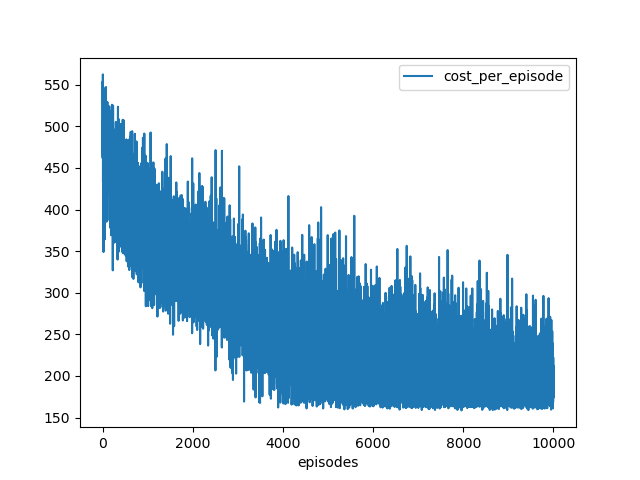

Text(0.5, 0, 'episodes')

In [24]:
plt.figure()
l = range(len(cost_episode))
plt.plot(l, cost_episode)
plt.legend(['cost_per_episode'])
plt.xlabel('episodes')

<IPython.core.display.Javascript object>


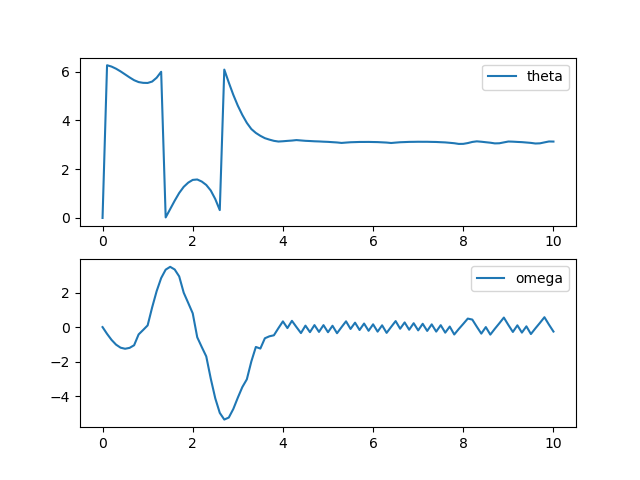

<IPython.core.display.Javascript object>


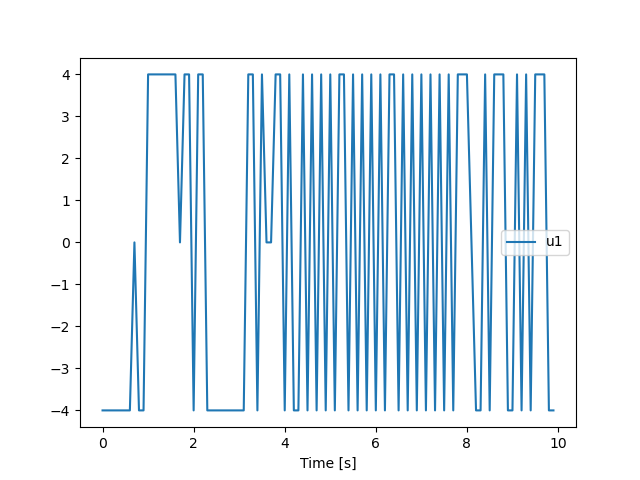

Text(0.5, 0, 'Time [s]')

In [10]:
# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')

In [11]:
# now we can also create an animation
pendulum.animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAgz1tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzA5NSBiYWVlNDAwIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DNRliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOONPsPaEewkllXn2fy
1TN9UNOLuVpCg16nA3KBIICjbY2TQND3n5QxoJFUYpmvY7NlYgUyYC0Gbe9iLYzS+7C8JQLMZGRo
QnlmwO88l0TfdHNayNY+bQVlMTywhlcWFi3wo5I9OWpDp/O5o69Dh9VCAAA7ArAJGcKIhsON1YTX
SZ+7DpOh956UxbX9JHiFm0hB1kTY014bpjWhUKbF1FKiWxxbaOI12ZNFiDZaGNwvH4gMJme2NhsB
5ycEpJAa5YCClinPEpetz3uLnx008RArAv0e7lBwVdLoRR8HR6ljB55JGV7+XQwNsLbloxnm0Jci
Y1GRGLBEdeoJvx//X6nip2NswUwAubMfy1/YSD/ic5nyOT5RA3uorBCtV2FftGmbYiXunqiOpVpK
I+2r/Ap+Q0WuKVcxKnkzawE1OQzWCRkf+/hKqsKQFeQo8ui0BLWjORcr7fRcv6mtXXQrHNZ5TLXy
vz07HuJ0r1jP1MHeAAstco/y6d/gZv97QP3wjOzkveqCynjnvrx6EsCzZ4ktjM8W1lNaV4DuFxm+
uCz0QBtjwO3A5ZbLNFqrcgL3Ukg4hJgKSbN1V7+QE4AAAAMAAAMAAC1tZ+0C8UCh2J0J5/pDiii5
fGN0lno0x71eIwtqvVtzZM5OWEQXCzJMSQ8wkDATruAlQZiLkYQ+di+wiiht8ZvNQdd8uR79qE1F
qvAk5pfFUnaB6zO6UwJib7iwEH6A1bJyuPPGD4rlIqCHsFXguGD2KPA1iP34Qw9JkAnzUcr/k2qn
KRU9EoLbicGmE1AZJwtiVcowVv+c0HKt6+sr5xFpRoDUImMcSRMReLZNXTkCCjy8n6nVH61qJhfm
hCO//LzUoKv77fnrjHfdW6zy0QmHYK98FRJTz1o90MVrW/Ku1u7uRgOuRnNp9LGfmQZvTGf9e6Q2
oms6hL3057RHcGNLz64VFsUozdy0kWmqno8+9da8otXThL9uPiNFrsJrBkwpMol+VB4STEO6WM/M
hEovk/e/h8eWrzX3BarKyfyA6qTDsE8UAAADAAADAAAlS6WQEQ48Job7NXZFUlyBtAepTYmAGtMO
wlHEyTrJrLusB9t0kV5mwYk13luBzCHdd0Tl8TFITDARLM/2lysOIf/37Tuf5iYy2Nc3f5DSPLlL
xX0CmJawL+yX7m+FgnEGuSesh9I0smzZcfWZ9IEZsZskpxRgeZyVuTklHAATTNLwlUNkvrB1wW8h
FfbHDV9tMS8iYnhYiokzQN3W93KKOTfRqPyuAm4bDR2F47ZwpSiGYXxPCIdtjfwusV6/jC8C12Sw
+EIykbRUuFalQCHmwxdhi+0KuMuBL4u1sHb9RlhWKGV8oQhOCNPy+tYmLRmPXVyW+u17l2UfLfss
kkQSakoZq6kUgi5nwCk+Gh9MhH03TMmKrSAZqZS5NGvwAGWoCiD0bFn5/4BXkN4m7su8YKcvFl2l
SvuN9M1mLzFlh8+gRMnR2fbyNCvVD2NtgqidHcESTGJxdaz9T9ZoRv1tlSl1RYHXJWYC7X5yPuuq
H1KShaEX9ebVOP3SocpPznKQqVYK6cKMvMqPJjX1Ai+2yPI+irlspGsSRAR2THrbb0oKwbg9RKPr
wdI/FdjwR+rxydhih4dJ/TPCYrhSAppP+bisAAADAAADAFrX/7B0mw/vfwYE9O41h69Mf9eLpyyL
+AcQ3VpJ87BMUeUyZEiWWKoQinDNOWa6jX9GmZLNWxj9pwciYj/p5JviHnWuI5lqlmDvIXm/WyYi
mGHtVu7l5ppfxQc4BihMWoEGl9/uMKUyCzQkF6IxWfrl4qoOsMFSBpgmB7+vNVKi5WKQfRoWAHwW
9eEGEqw2e209ELLJxHTbJuVCm48rkIUPIV7p42OYLZrHnFBRt/p03Wk7f+7qt5bzFzK28amIb3vR
n2rwPM4+bsKTSebEF0ZjqaCBfp97z66qXE23f6NKjnZyi60XsQcy1MLxoPrQtGQ9LwWY3zTtWH5p
uvPYq9XkqCfKr/LSUYigbvl//bwy5JWpwrNMQ8G6WFUUk2pEtUow3l2kz7EVhnFYovkcTTjWvFY4
+yTMA/qvdeuxg9oggVI3JvNYG3w/I/Zw5MuKTyIhkyU1Xh1d1K/sn4bYGKFCE/r9t/v8Fu9vvX2Y
wW0os9+7vmL7XMkVFj66rgOkpa3ZxAZCrK3fa+sXwGviCoJQwDC+SMIlnFmeEWhyaFLDo7OuCA64
7Btn5i1ULR0g4PXlfuXEd+c4IAAAlI3/bk7gAsaato5IP5/rrAAMawSKOgiy9etOGS4BoTd1JgJp
Rs3HYA2VTMpIbGY2lhZKKY9Tx+tzla72yBmTAOWI8YSLzHd6JN/Lqr55ynagVCWaqL0RKjjFxnX1
XXkYDRqUCtKUjv/CrhB92pZ7ioA69Jgm607Fxd+bnYNnIMgtVU+M7W5waExqwcERT6FcAUTKNvXA
sHwMEF25ehlm3+AQTxP+nrhgee2tslRWQ8+qwGzOntpHwyAEM0eeg82M5kZXxIi9d3uSr5pebYFx
57khAgkB5g6pjtY5iHiNvz3p5yHas5/1Kx2dw8YZkDzHFptAivlCOirCNY9Uwv+SIqXDsId89b38
pLWw+Woa2BI71UrTEH4gCrdVChJvyq21T/RBogBeaP/EnSZqGf86tx2/zL+g0kzrX+cqs0SwBb+c
Xw+GjwtpPxfD52QFqEfwroepKYzd5xxcPMHbLi+ntvRxA0KImaKLz5CpWzpUMm9hE23vNlmNxODR
2v4OR36tH6UkUSWrU1cel

We also need to discretize the state space, we discretize $\theta \in [0, 2\pi]$ in 50 states and $\dot{\theta} \in [-6, 6]$ is 50 states. For example:

<IPython.core.display.Javascript object>


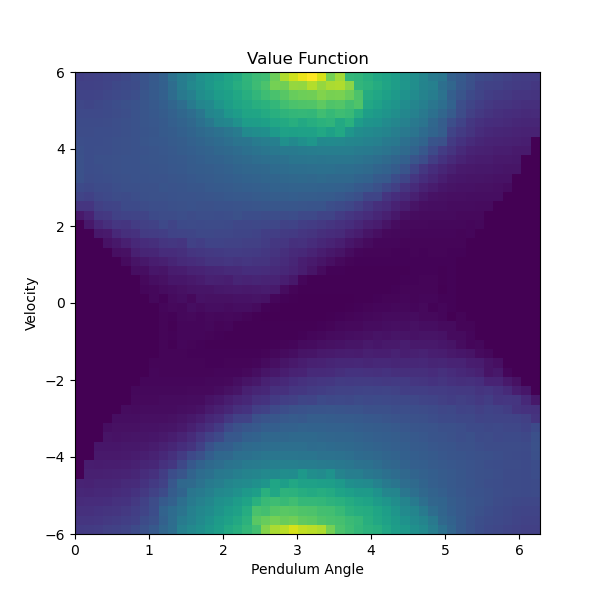

<IPython.core.display.Javascript object>


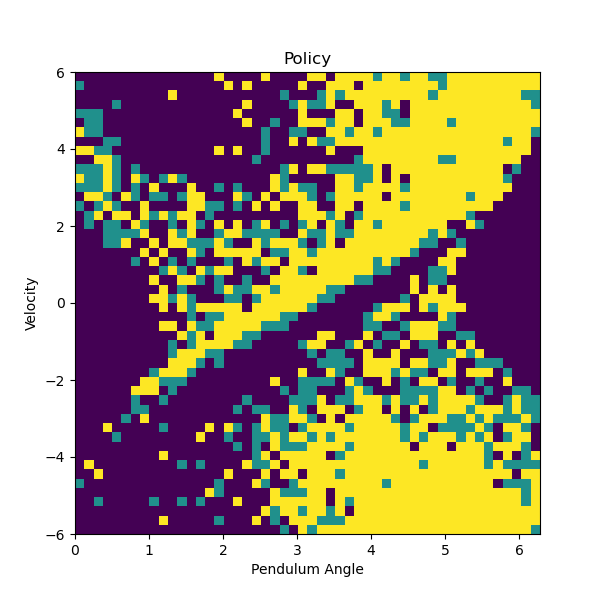

Text(0.5, 1.0, 'Policy')

In [25]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2

value_function, policy = get_policy_and_value_function(q_table)

# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')

In [26]:
### For control of [-5, 0, 5]

In [33]:
episodes = 10000
q_table = np.zeros([3,50,50])
controls = np.array([-5,0,5])

cost_episode = []

for episode in range(episodes):

    new_q_table = q_learning(q_table, episode)
    q_table = new_q_table
    

Current Episode 0 Cost:502.74708690046884
Current Episode 200 Cost:484.35655038312376
Current Episode 400 Cost:371.56907571285655
Current Episode 600 Cost:410.91914887775954
Current Episode 800 Cost:366.4200925351304
goal reached at step 96 and episode 894
goal reached at step 97 and episode 894
goal reached at step 95 and episode 896
Current Episode 1000 Cost:369.334982309401
Current Episode 1200 Cost:344.2499496484061
goal reached at step 80 and episode 1310
goal reached at step 81 and episode 1310
goal reached at step 85 and episode 1370
Current Episode 1400 Cost:324.58202851204226
goal reached at step 85 and episode 1411
goal reached at step 86 and episode 1411
goal reached at step 70 and episode 1508
goal reached at step 72 and episode 1508
goal reached at step 73 and episode 1508
goal reached at step 74 and episode 1508
goal reached at step 75 and episode 1508
goal reached at step 76 and episode 1508
goal reached at step 77 and episode 1508
goal reached at step 78 and episode 150

goal reached at step 95 and episode 2682
goal reached at step 96 and episode 2682
goal reached at step 68 and episode 2687
goal reached at step 70 and episode 2687
goal reached at step 72 and episode 2687
goal reached at step 73 and episode 2687
goal reached at step 91 and episode 2688
goal reached at step 52 and episode 2697
goal reached at step 53 and episode 2697
goal reached at step 55 and episode 2697
goal reached at step 97 and episode 2702
goal reached at step 81 and episode 2705
goal reached at step 90 and episode 2705
goal reached at step 94 and episode 2717
goal reached at step 58 and episode 2721
goal reached at step 59 and episode 2721
goal reached at step 60 and episode 2721
goal reached at step 61 and episode 2721
goal reached at step 83 and episode 2730
goal reached at step 65 and episode 2738
goal reached at step 67 and episode 2738
goal reached at step 76 and episode 2739
goal reached at step 84 and episode 2742
goal reached at step 86 and episode 2742
goal reached at 

goal reached at step 68 and episode 3101
goal reached at step 67 and episode 3103
goal reached at step 81 and episode 3103
goal reached at step 83 and episode 3103
goal reached at step 95 and episode 3104
goal reached at step 51 and episode 3106
goal reached at step 52 and episode 3106
goal reached at step 53 and episode 3106
goal reached at step 58 and episode 3106
goal reached at step 59 and episode 3106
goal reached at step 60 and episode 3106
goal reached at step 66 and episode 3106
goal reached at step 68 and episode 3106
goal reached at step 75 and episode 3106
goal reached at step 77 and episode 3106
goal reached at step 87 and episode 3106
goal reached at step 92 and episode 3106
goal reached at step 93 and episode 3106
goal reached at step 94 and episode 3106
goal reached at step 95 and episode 3106
goal reached at step 96 and episode 3106
goal reached at step 97 and episode 3106
goal reached at step 62 and episode 3110
goal reached at step 64 and episode 3110
goal reached at 

goal reached at step 58 and episode 3345
goal reached at step 60 and episode 3345
goal reached at step 61 and episode 3345
goal reached at step 70 and episode 3346
goal reached at step 81 and episode 3347
goal reached at step 82 and episode 3347
goal reached at step 83 and episode 3347
goal reached at step 84 and episode 3347
goal reached at step 99 and episode 3347
goal reached at step 49 and episode 3353
goal reached at step 93 and episode 3353
goal reached at step 95 and episode 3353
goal reached at step 97 and episode 3353
goal reached at step 67 and episode 3358
goal reached at step 72 and episode 3358
goal reached at step 73 and episode 3358
goal reached at step 74 and episode 3358
goal reached at step 75 and episode 3358
goal reached at step 76 and episode 3358
goal reached at step 77 and episode 3358
goal reached at step 86 and episode 3358
goal reached at step 79 and episode 3359
goal reached at step 81 and episode 3359
goal reached at step 83 and episode 3359
goal reached at 

goal reached at step 94 and episode 3573
goal reached at step 96 and episode 3573
goal reached at step 98 and episode 3573
goal reached at step 93 and episode 3575
goal reached at step 95 and episode 3575
goal reached at step 78 and episode 3580
goal reached at step 49 and episode 3584
goal reached at step 50 and episode 3584
goal reached at step 51 and episode 3584
goal reached at step 52 and episode 3584
goal reached at step 56 and episode 3584
goal reached at step 72 and episode 3584
goal reached at step 74 and episode 3584
goal reached at step 94 and episode 3584
goal reached at step 95 and episode 3584
goal reached at step 96 and episode 3584
goal reached at step 71 and episode 3585
goal reached at step 72 and episode 3585
goal reached at step 73 and episode 3585
goal reached at step 74 and episode 3585
goal reached at step 75 and episode 3585
goal reached at step 76 and episode 3585
goal reached at step 81 and episode 3585
goal reached at step 83 and episode 3585
goal reached at 

goal reached at step 90 and episode 3707
goal reached at step 91 and episode 3707
goal reached at step 92 and episode 3707
goal reached at step 93 and episode 3707
goal reached at step 96 and episode 3707
goal reached at step 97 and episode 3707
goal reached at step 98 and episode 3707
goal reached at step 99 and episode 3707
goal reached at step 44 and episode 3710
goal reached at step 45 and episode 3710
goal reached at step 46 and episode 3710
goal reached at step 47 and episode 3710
goal reached at step 48 and episode 3710
goal reached at step 47 and episode 3711
goal reached at step 49 and episode 3711
goal reached at step 51 and episode 3711
goal reached at step 53 and episode 3711
goal reached at step 55 and episode 3711
goal reached at step 88 and episode 3713
goal reached at step 89 and episode 3713
goal reached at step 88 and episode 3714
goal reached at step 60 and episode 3715
goal reached at step 61 and episode 3715
goal reached at step 67 and episode 3715
goal reached at 

goal reached at step 71 and episode 3826
goal reached at step 73 and episode 3826
goal reached at step 78 and episode 3826
goal reached at step 91 and episode 3826
goal reached at step 93 and episode 3826
goal reached at step 99 and episode 3826
goal reached at step 62 and episode 3827
goal reached at step 63 and episode 3827
goal reached at step 64 and episode 3827
goal reached at step 65 and episode 3827
goal reached at step 66 and episode 3827
goal reached at step 68 and episode 3827
goal reached at step 69 and episode 3827
goal reached at step 70 and episode 3827
goal reached at step 71 and episode 3827
goal reached at step 72 and episode 3827
goal reached at step 73 and episode 3827
goal reached at step 74 and episode 3827
goal reached at step 75 and episode 3827
goal reached at step 76 and episode 3827
goal reached at step 77 and episode 3827
goal reached at step 81 and episode 3827
goal reached at step 82 and episode 3827
goal reached at step 78 and episode 3831
goal reached at 

goal reached at step 91 and episode 4020
goal reached at step 96 and episode 4020
goal reached at step 97 and episode 4020
goal reached at step 50 and episode 4021
goal reached at step 51 and episode 4021
goal reached at step 52 and episode 4021
goal reached at step 53 and episode 4021
goal reached at step 54 and episode 4021
goal reached at step 63 and episode 4021
goal reached at step 64 and episode 4021
goal reached at step 65 and episode 4021
goal reached at step 66 and episode 4021
goal reached at step 70 and episode 4021
goal reached at step 73 and episode 4021
goal reached at step 51 and episode 4023
goal reached at step 58 and episode 4023
goal reached at step 60 and episode 4023
goal reached at step 62 and episode 4023
goal reached at step 82 and episode 4023
goal reached at step 61 and episode 4024
goal reached at step 79 and episode 4024
goal reached at step 88 and episode 4024
goal reached at step 90 and episode 4024
goal reached at step 92 and episode 4024
goal reached at 

goal reached at step 76 and episode 4086
goal reached at step 99 and episode 4088
goal reached at step 62 and episode 4089
goal reached at step 64 and episode 4089
goal reached at step 66 and episode 4089
goal reached at step 93 and episode 4089
goal reached at step 42 and episode 4092
goal reached at step 43 and episode 4092
goal reached at step 44 and episode 4092
goal reached at step 51 and episode 4092
goal reached at step 52 and episode 4092
goal reached at step 58 and episode 4092
goal reached at step 60 and episode 4092
goal reached at step 61 and episode 4092
goal reached at step 62 and episode 4092
goal reached at step 63 and episode 4092
goal reached at step 64 and episode 4092
goal reached at step 68 and episode 4092
goal reached at step 69 and episode 4092
goal reached at step 70 and episode 4092
goal reached at step 71 and episode 4092
goal reached at step 89 and episode 4092
goal reached at step 97 and episode 4092
goal reached at step 55 and episode 4093
goal reached at 

goal reached at step 85 and episode 4176
goal reached at step 96 and episode 4176
goal reached at step 97 and episode 4176
goal reached at step 56 and episode 4179
goal reached at step 57 and episode 4179
goal reached at step 58 and episode 4179
goal reached at step 59 and episode 4179
goal reached at step 60 and episode 4179
goal reached at step 61 and episode 4179
goal reached at step 67 and episode 4179
goal reached at step 73 and episode 4179
goal reached at step 74 and episode 4179
goal reached at step 61 and episode 4180
goal reached at step 62 and episode 4180
goal reached at step 63 and episode 4180
goal reached at step 64 and episode 4180
goal reached at step 65 and episode 4180
goal reached at step 66 and episode 4180
goal reached at step 71 and episode 4180
goal reached at step 73 and episode 4180
goal reached at step 74 and episode 4180
goal reached at step 75 and episode 4180
goal reached at step 76 and episode 4180
goal reached at step 77 and episode 4180
goal reached at 

goal reached at step 66 and episode 4270
goal reached at step 68 and episode 4270
goal reached at step 73 and episode 4270
goal reached at step 74 and episode 4270
goal reached at step 75 and episode 4270
goal reached at step 76 and episode 4270
goal reached at step 77 and episode 4270
goal reached at step 78 and episode 4270
goal reached at step 82 and episode 4270
goal reached at step 84 and episode 4270
goal reached at step 87 and episode 4270
goal reached at step 93 and episode 4270
goal reached at step 78 and episode 4272
goal reached at step 80 and episode 4272
goal reached at step 82 and episode 4272
goal reached at step 87 and episode 4272
goal reached at step 89 and episode 4272
goal reached at step 90 and episode 4272
goal reached at step 96 and episode 4272
goal reached at step 83 and episode 4273
goal reached at step 95 and episode 4273
goal reached at step 97 and episode 4273
goal reached at step 57 and episode 4274
goal reached at step 59 and episode 4274
goal reached at 

goal reached at step 62 and episode 4358
goal reached at step 88 and episode 4358
goal reached at step 89 and episode 4358
goal reached at step 80 and episode 4360
goal reached at step 81 and episode 4360
goal reached at step 82 and episode 4360
goal reached at step 83 and episode 4360
goal reached at step 85 and episode 4360
goal reached at step 90 and episode 4360
goal reached at step 91 and episode 4360
goal reached at step 96 and episode 4360
goal reached at step 97 and episode 4360
goal reached at step 36 and episode 4361
goal reached at step 37 and episode 4361
goal reached at step 38 and episode 4361
goal reached at step 39 and episode 4361
goal reached at step 58 and episode 4361
goal reached at step 59 and episode 4361
goal reached at step 60 and episode 4361
goal reached at step 61 and episode 4361
goal reached at step 62 and episode 4361
goal reached at step 81 and episode 4361
goal reached at step 86 and episode 4361
goal reached at step 88 and episode 4361
goal reached at 

goal reached at step 57 and episode 4428
goal reached at step 71 and episode 4428
goal reached at step 73 and episode 4428
goal reached at step 80 and episode 4428
goal reached at step 82 and episode 4428
goal reached at step 84 and episode 4428
goal reached at step 86 and episode 4428
goal reached at step 71 and episode 4430
goal reached at step 73 and episode 4430
goal reached at step 75 and episode 4430
goal reached at step 77 and episode 4430
goal reached at step 92 and episode 4430
goal reached at step 94 and episode 4430
goal reached at step 96 and episode 4430
goal reached at step 98 and episode 4431
goal reached at step 94 and episode 4433
goal reached at step 96 and episode 4433
goal reached at step 98 and episode 4433
goal reached at step 45 and episode 4434
goal reached at step 47 and episode 4434
goal reached at step 49 and episode 4434
goal reached at step 51 and episode 4434
goal reached at step 43 and episode 4435
goal reached at step 66 and episode 4435
goal reached at 

goal reached at step 99 and episode 4522
goal reached at step 45 and episode 4524
goal reached at step 47 and episode 4524
goal reached at step 48 and episode 4524
goal reached at step 51 and episode 4524
goal reached at step 53 and episode 4524
goal reached at step 55 and episode 4524
goal reached at step 57 and episode 4524
goal reached at step 97 and episode 4526
goal reached at step 98 and episode 4526
goal reached at step 99 and episode 4526
goal reached at step 51 and episode 4528
goal reached at step 52 and episode 4528
goal reached at step 62 and episode 4528
goal reached at step 63 and episode 4528
goal reached at step 64 and episode 4528
goal reached at step 65 and episode 4528
goal reached at step 66 and episode 4528
goal reached at step 71 and episode 4528
goal reached at step 72 and episode 4528
goal reached at step 73 and episode 4528
goal reached at step 74 and episode 4528
goal reached at step 75 and episode 4528
goal reached at step 87 and episode 4528
goal reached at 

goal reached at step 40 and episode 4641
goal reached at step 41 and episode 4641
goal reached at step 80 and episode 4641
goal reached at step 81 and episode 4641
goal reached at step 82 and episode 4641
goal reached at step 87 and episode 4641
goal reached at step 88 and episode 4641
goal reached at step 89 and episode 4641
goal reached at step 95 and episode 4641
goal reached at step 44 and episode 4642
goal reached at step 45 and episode 4642
goal reached at step 46 and episode 4642
goal reached at step 47 and episode 4642
goal reached at step 48 and episode 4642
goal reached at step 49 and episode 4642
goal reached at step 50 and episode 4642
goal reached at step 51 and episode 4642
goal reached at step 52 and episode 4642
goal reached at step 53 and episode 4642
goal reached at step 73 and episode 4642
goal reached at step 77 and episode 4642
goal reached at step 78 and episode 4642
goal reached at step 79 and episode 4642
goal reached at step 80 and episode 4642
goal reached at 

goal reached at step 83 and episode 4715
goal reached at step 85 and episode 4715
goal reached at step 87 and episode 4715
goal reached at step 89 and episode 4715
goal reached at step 91 and episode 4715
goal reached at step 93 and episode 4715
goal reached at step 95 and episode 4715
goal reached at step 52 and episode 4716
goal reached at step 54 and episode 4716
goal reached at step 56 and episode 4716
goal reached at step 65 and episode 4716
goal reached at step 67 and episode 4716
goal reached at step 71 and episode 4716
goal reached at step 73 and episode 4716
goal reached at step 77 and episode 4716
goal reached at step 78 and episode 4716
goal reached at step 79 and episode 4716
goal reached at step 80 and episode 4716
goal reached at step 81 and episode 4716
goal reached at step 82 and episode 4716
goal reached at step 83 and episode 4716
goal reached at step 84 and episode 4716
goal reached at step 88 and episode 4716
goal reached at step 89 and episode 4716
goal reached at 

goal reached at step 40 and episode 4819
goal reached at step 51 and episode 4819
goal reached at step 53 and episode 4819
goal reached at step 57 and episode 4819
goal reached at step 61 and episode 4819
goal reached at step 63 and episode 4819
goal reached at step 64 and episode 4819
goal reached at step 65 and episode 4819
goal reached at step 66 and episode 4819
goal reached at step 67 and episode 4819
goal reached at step 72 and episode 4819
goal reached at step 73 and episode 4819
goal reached at step 85 and episode 4819
goal reached at step 86 and episode 4819
goal reached at step 66 and episode 4820
goal reached at step 67 and episode 4820
goal reached at step 68 and episode 4820
goal reached at step 70 and episode 4820
goal reached at step 79 and episode 4820
goal reached at step 84 and episode 4820
goal reached at step 89 and episode 4820
goal reached at step 90 and episode 4820
goal reached at step 92 and episode 4820
goal reached at step 94 and episode 4820
goal reached at 

goal reached at step 84 and episode 4878
goal reached at step 85 and episode 4878
goal reached at step 92 and episode 4878
goal reached at step 93 and episode 4878
goal reached at step 97 and episode 4878
goal reached at step 98 and episode 4878
goal reached at step 99 and episode 4878
goal reached at step 63 and episode 4879
goal reached at step 68 and episode 4879
goal reached at step 74 and episode 4879
goal reached at step 75 and episode 4879
goal reached at step 91 and episode 4879
goal reached at step 92 and episode 4879
goal reached at step 93 and episode 4879
goal reached at step 94 and episode 4879
goal reached at step 95 and episode 4879
goal reached at step 61 and episode 4880
goal reached at step 66 and episode 4880
goal reached at step 67 and episode 4880
goal reached at step 68 and episode 4880
goal reached at step 69 and episode 4880
goal reached at step 73 and episode 4880
goal reached at step 74 and episode 4880
goal reached at step 75 and episode 4880
goal reached at 

goal reached at step 62 and episode 4961
goal reached at step 63 and episode 4961
goal reached at step 68 and episode 4961
goal reached at step 69 and episode 4961
goal reached at step 70 and episode 4961
goal reached at step 71 and episode 4961
goal reached at step 72 and episode 4961
goal reached at step 77 and episode 4961
goal reached at step 78 and episode 4961
goal reached at step 79 and episode 4961
goal reached at step 83 and episode 4961
goal reached at step 84 and episode 4961
goal reached at step 85 and episode 4961
goal reached at step 89 and episode 4961
goal reached at step 90 and episode 4961
goal reached at step 91 and episode 4961
goal reached at step 77 and episode 4962
goal reached at step 83 and episode 4962
goal reached at step 84 and episode 4962
goal reached at step 85 and episode 4962
goal reached at step 96 and episode 4962
goal reached at step 57 and episode 4963
goal reached at step 58 and episode 4963
goal reached at step 64 and episode 4963
goal reached at 

goal reached at step 96 and episode 5119
goal reached at step 68 and episode 5122
goal reached at step 69 and episode 5122
goal reached at step 73 and episode 5122
goal reached at step 74 and episode 5122
goal reached at step 75 and episode 5122
goal reached at step 83 and episode 5122
goal reached at step 89 and episode 5122
goal reached at step 96 and episode 5122
goal reached at step 99 and episode 5122
goal reached at step 74 and episode 5123
goal reached at step 76 and episode 5123
goal reached at step 78 and episode 5123
goal reached at step 84 and episode 5123
goal reached at step 97 and episode 5123
goal reached at step 56 and episode 5124
goal reached at step 58 and episode 5124
goal reached at step 63 and episode 5124
goal reached at step 65 and episode 5124
goal reached at step 67 and episode 5124
goal reached at step 75 and episode 5124
goal reached at step 77 and episode 5124
goal reached at step 42 and episode 5125
goal reached at step 47 and episode 5125
goal reached at 

goal reached at step 48 and episode 5197
goal reached at step 49 and episode 5197
goal reached at step 50 and episode 5197
goal reached at step 51 and episode 5197
goal reached at step 52 and episode 5197
goal reached at step 53 and episode 5197
goal reached at step 57 and episode 5197
goal reached at step 58 and episode 5197
goal reached at step 59 and episode 5197
goal reached at step 63 and episode 5197
goal reached at step 64 and episode 5197
goal reached at step 65 and episode 5197
goal reached at step 66 and episode 5197
goal reached at step 67 and episode 5197
goal reached at step 71 and episode 5197
goal reached at step 72 and episode 5197
goal reached at step 73 and episode 5197
goal reached at step 75 and episode 5197
goal reached at step 80 and episode 5197
goal reached at step 81 and episode 5197
goal reached at step 50 and episode 5198
goal reached at step 51 and episode 5198
goal reached at step 52 and episode 5198
goal reached at step 55 and episode 5198
goal reached at 

goal reached at step 47 and episode 5235
goal reached at step 49 and episode 5235
goal reached at step 51 and episode 5235
goal reached at step 53 and episode 5235
goal reached at step 55 and episode 5235
goal reached at step 62 and episode 5235
goal reached at step 64 and episode 5235
goal reached at step 66 and episode 5235
goal reached at step 68 and episode 5235
goal reached at step 73 and episode 5235
goal reached at step 74 and episode 5235
goal reached at step 75 and episode 5235
goal reached at step 76 and episode 5235
goal reached at step 77 and episode 5235
goal reached at step 83 and episode 5235
goal reached at step 56 and episode 5236
goal reached at step 57 and episode 5236
goal reached at step 59 and episode 5236
goal reached at step 60 and episode 5236
goal reached at step 62 and episode 5236
goal reached at step 66 and episode 5236
goal reached at step 67 and episode 5236
goal reached at step 86 and episode 5236
goal reached at step 87 and episode 5236
goal reached at 

goal reached at step 94 and episode 5385
goal reached at step 95 and episode 5385
goal reached at step 96 and episode 5385
goal reached at step 88 and episode 5386
goal reached at step 92 and episode 5386
goal reached at step 93 and episode 5386
goal reached at step 52 and episode 5388
goal reached at step 54 and episode 5388
goal reached at step 55 and episode 5388
goal reached at step 56 and episode 5388
goal reached at step 60 and episode 5388
goal reached at step 61 and episode 5388
goal reached at step 62 and episode 5388
goal reached at step 63 and episode 5388
goal reached at step 64 and episode 5388
goal reached at step 82 and episode 5388
goal reached at step 89 and episode 5388
goal reached at step 90 and episode 5388
goal reached at step 56 and episode 5389
goal reached at step 57 and episode 5389
goal reached at step 58 and episode 5389
goal reached at step 59 and episode 5389
goal reached at step 60 and episode 5389
goal reached at step 61 and episode 5389
goal reached at 

goal reached at step 72 and episode 5520
goal reached at step 73 and episode 5520
goal reached at step 74 and episode 5520
goal reached at step 75 and episode 5520
goal reached at step 76 and episode 5520
goal reached at step 77 and episode 5520
goal reached at step 82 and episode 5520
goal reached at step 93 and episode 5520
goal reached at step 94 and episode 5520
goal reached at step 95 and episode 5520
goal reached at step 97 and episode 5520
goal reached at step 98 and episode 5520
goal reached at step 99 and episode 5520
goal reached at step 57 and episode 5521
goal reached at step 58 and episode 5521
goal reached at step 59 and episode 5521
goal reached at step 67 and episode 5521
goal reached at step 68 and episode 5521
goal reached at step 69 and episode 5521
goal reached at step 70 and episode 5521
goal reached at step 73 and episode 5521
goal reached at step 75 and episode 5521
goal reached at step 76 and episode 5521
goal reached at step 86 and episode 5521
goal reached at 

goal reached at step 39 and episode 5640
goal reached at step 50 and episode 5640
goal reached at step 55 and episode 5640
goal reached at step 63 and episode 5640
goal reached at step 65 and episode 5640
goal reached at step 67 and episode 5640
goal reached at step 69 and episode 5640
goal reached at step 71 and episode 5640
goal reached at step 78 and episode 5640
goal reached at step 79 and episode 5640
goal reached at step 80 and episode 5640
goal reached at step 84 and episode 5640
goal reached at step 85 and episode 5640
goal reached at step 86 and episode 5640
goal reached at step 87 and episode 5640
goal reached at step 97 and episode 5640
goal reached at step 77 and episode 5641
goal reached at step 78 and episode 5641
goal reached at step 79 and episode 5641
goal reached at step 80 and episode 5641
goal reached at step 81 and episode 5641
goal reached at step 82 and episode 5641
goal reached at step 83 and episode 5641
goal reached at step 84 and episode 5641
goal reached at 

goal reached at step 59 and episode 5669
goal reached at step 61 and episode 5669
goal reached at step 63 and episode 5669
goal reached at step 72 and episode 5669
goal reached at step 77 and episode 5669
goal reached at step 79 and episode 5669
goal reached at step 89 and episode 5669
goal reached at step 91 and episode 5669
goal reached at step 93 and episode 5669
goal reached at step 95 and episode 5669
goal reached at step 52 and episode 5670
goal reached at step 54 and episode 5670
goal reached at step 56 and episode 5670
goal reached at step 61 and episode 5670
goal reached at step 62 and episode 5670
goal reached at step 63 and episode 5670
goal reached at step 64 and episode 5670
goal reached at step 65 and episode 5670
goal reached at step 66 and episode 5670
goal reached at step 67 and episode 5670
goal reached at step 68 and episode 5670
goal reached at step 69 and episode 5670
goal reached at step 70 and episode 5670
goal reached at step 71 and episode 5670
goal reached at 

goal reached at step 99 and episode 5763
goal reached at step 57 and episode 5765
goal reached at step 65 and episode 5765
goal reached at step 66 and episode 5765
goal reached at step 71 and episode 5765
goal reached at step 72 and episode 5765
goal reached at step 78 and episode 5765
goal reached at step 79 and episode 5765
goal reached at step 86 and episode 5765
goal reached at step 87 and episode 5765
goal reached at step 88 and episode 5765
goal reached at step 93 and episode 5765
goal reached at step 94 and episode 5765
goal reached at step 99 and episode 5765
goal reached at step 51 and episode 5766
goal reached at step 52 and episode 5766
goal reached at step 53 and episode 5766
goal reached at step 54 and episode 5766
goal reached at step 59 and episode 5766
goal reached at step 60 and episode 5766
goal reached at step 65 and episode 5766
goal reached at step 72 and episode 5766
goal reached at step 74 and episode 5766
goal reached at step 77 and episode 5766
goal reached at 

goal reached at step 52 and episode 5800
goal reached at step 57 and episode 5800
goal reached at step 59 and episode 5800
goal reached at step 61 and episode 5800
goal reached at step 79 and episode 5800
goal reached at step 81 and episode 5800
goal reached at step 83 and episode 5800
goal reached at step 85 and episode 5800
goal reached at step 86 and episode 5800
goal reached at step 91 and episode 5800
goal reached at step 93 and episode 5800
goal reached at step 95 and episode 5800
goal reached at step 97 and episode 5800
Current Episode 5800 Cost:166.2053099897705
goal reached at step 45 and episode 5801
goal reached at step 61 and episode 5801
goal reached at step 72 and episode 5801
goal reached at step 73 and episode 5801
goal reached at step 74 and episode 5801
goal reached at step 67 and episode 5802
goal reached at step 68 and episode 5802
goal reached at step 73 and episode 5802
goal reached at step 74 and episode 5802
goal reached at step 78 and episode 5802
goal reached 

goal reached at step 53 and episode 5877
goal reached at step 54 and episode 5877
goal reached at step 55 and episode 5877
goal reached at step 59 and episode 5877
goal reached at step 60 and episode 5877
goal reached at step 61 and episode 5877
goal reached at step 62 and episode 5877
goal reached at step 63 and episode 5877
goal reached at step 64 and episode 5877
goal reached at step 65 and episode 5877
goal reached at step 67 and episode 5877
goal reached at step 68 and episode 5877
goal reached at step 69 and episode 5877
goal reached at step 74 and episode 5877
goal reached at step 75 and episode 5877
goal reached at step 79 and episode 5877
goal reached at step 80 and episode 5877
goal reached at step 81 and episode 5877
goal reached at step 92 and episode 5877
goal reached at step 97 and episode 5877
goal reached at step 98 and episode 5877
goal reached at step 99 and episode 5877
goal reached at step 44 and episode 5878
goal reached at step 51 and episode 5878
goal reached at 

goal reached at step 85 and episode 5963
goal reached at step 86 and episode 5963
goal reached at step 87 and episode 5963
goal reached at step 88 and episode 5963
goal reached at step 45 and episode 5964
goal reached at step 46 and episode 5964
goal reached at step 47 and episode 5964
goal reached at step 53 and episode 5964
goal reached at step 54 and episode 5964
goal reached at step 56 and episode 5964
goal reached at step 57 and episode 5964
goal reached at step 61 and episode 5964
goal reached at step 62 and episode 5964
goal reached at step 63 and episode 5964
goal reached at step 71 and episode 5964
goal reached at step 75 and episode 5964
goal reached at step 76 and episode 5964
goal reached at step 77 and episode 5964
goal reached at step 78 and episode 5964
goal reached at step 86 and episode 5964
goal reached at step 91 and episode 5964
goal reached at step 92 and episode 5964
goal reached at step 93 and episode 5964
goal reached at step 94 and episode 5964
goal reached at 

goal reached at step 89 and episode 5995
goal reached at step 90 and episode 5995
goal reached at step 91 and episode 5995
goal reached at step 92 and episode 5995
goal reached at step 93 and episode 5995
goal reached at step 94 and episode 5995
goal reached at step 95 and episode 5995
goal reached at step 96 and episode 5995
goal reached at step 97 and episode 5995
goal reached at step 98 and episode 5995
goal reached at step 49 and episode 5996
goal reached at step 50 and episode 5996
goal reached at step 51 and episode 5996
goal reached at step 57 and episode 5996
goal reached at step 58 and episode 5996
goal reached at step 70 and episode 5996
goal reached at step 71 and episode 5996
goal reached at step 72 and episode 5996
goal reached at step 73 and episode 5996
goal reached at step 77 and episode 5996
goal reached at step 78 and episode 5996
goal reached at step 79 and episode 5996
goal reached at step 56 and episode 5997
goal reached at step 57 and episode 5997
goal reached at 

goal reached at step 72 and episode 6022
goal reached at step 50 and episode 6023
goal reached at step 51 and episode 6023
goal reached at step 52 and episode 6023
goal reached at step 56 and episode 6023
goal reached at step 57 and episode 6023
goal reached at step 58 and episode 6023
goal reached at step 60 and episode 6023
goal reached at step 62 and episode 6023
goal reached at step 63 and episode 6023
goal reached at step 64 and episode 6023
goal reached at step 65 and episode 6023
goal reached at step 66 and episode 6023
goal reached at step 67 and episode 6023
goal reached at step 68 and episode 6023
goal reached at step 69 and episode 6023
goal reached at step 70 and episode 6023
goal reached at step 71 and episode 6023
goal reached at step 72 and episode 6023
goal reached at step 73 and episode 6023
goal reached at step 74 and episode 6023
goal reached at step 75 and episode 6023
goal reached at step 76 and episode 6023
goal reached at step 77 and episode 6023
goal reached at 

goal reached at step 46 and episode 6073
goal reached at step 47 and episode 6073
goal reached at step 48 and episode 6073
goal reached at step 49 and episode 6073
goal reached at step 50 and episode 6073
goal reached at step 51 and episode 6073
goal reached at step 56 and episode 6073
goal reached at step 57 and episode 6073
goal reached at step 59 and episode 6073
goal reached at step 60 and episode 6073
goal reached at step 61 and episode 6073
goal reached at step 66 and episode 6073
goal reached at step 67 and episode 6073
goal reached at step 72 and episode 6073
goal reached at step 73 and episode 6073
goal reached at step 74 and episode 6073
goal reached at step 75 and episode 6073
goal reached at step 80 and episode 6073
goal reached at step 81 and episode 6073
goal reached at step 86 and episode 6073
goal reached at step 87 and episode 6073
goal reached at step 88 and episode 6073
goal reached at step 93 and episode 6073
goal reached at step 94 and episode 6073
goal reached at 

goal reached at step 80 and episode 6208
goal reached at step 84 and episode 6208
goal reached at step 85 and episode 6208
goal reached at step 86 and episode 6208
goal reached at step 87 and episode 6208
goal reached at step 88 and episode 6208
goal reached at step 92 and episode 6208
goal reached at step 93 and episode 6208
goal reached at step 94 and episode 6208
goal reached at step 95 and episode 6208
goal reached at step 96 and episode 6208
goal reached at step 62 and episode 6209
goal reached at step 63 and episode 6209
goal reached at step 71 and episode 6209
goal reached at step 89 and episode 6209
goal reached at step 90 and episode 6209
goal reached at step 95 and episode 6209
goal reached at step 96 and episode 6209
goal reached at step 97 and episode 6209
goal reached at step 72 and episode 6210
goal reached at step 73 and episode 6210
goal reached at step 74 and episode 6210
goal reached at step 75 and episode 6210
goal reached at step 76 and episode 6210
goal reached at 

goal reached at step 41 and episode 6257
goal reached at step 42 and episode 6257
goal reached at step 43 and episode 6257
goal reached at step 44 and episode 6257
goal reached at step 55 and episode 6257
goal reached at step 56 and episode 6257
goal reached at step 57 and episode 6257
goal reached at step 59 and episode 6257
goal reached at step 60 and episode 6257
goal reached at step 61 and episode 6257
goal reached at step 65 and episode 6257
goal reached at step 66 and episode 6257
goal reached at step 67 and episode 6257
goal reached at step 72 and episode 6257
goal reached at step 73 and episode 6257
goal reached at step 74 and episode 6257
goal reached at step 75 and episode 6257
goal reached at step 89 and episode 6257
goal reached at step 90 and episode 6257
goal reached at step 95 and episode 6257
goal reached at step 96 and episode 6257
goal reached at step 51 and episode 6258
goal reached at step 52 and episode 6258
goal reached at step 53 and episode 6258
goal reached at 

goal reached at step 66 and episode 6405
goal reached at step 71 and episode 6405
goal reached at step 73 and episode 6405
goal reached at step 77 and episode 6405
goal reached at step 78 and episode 6405
goal reached at step 79 and episode 6405
goal reached at step 80 and episode 6405
goal reached at step 81 and episode 6405
goal reached at step 85 and episode 6405
goal reached at step 86 and episode 6405
goal reached at step 87 and episode 6405
goal reached at step 74 and episode 6406
goal reached at step 79 and episode 6406
goal reached at step 80 and episode 6406
goal reached at step 85 and episode 6406
goal reached at step 87 and episode 6406
goal reached at step 43 and episode 6407
goal reached at step 51 and episode 6407
goal reached at step 56 and episode 6407
goal reached at step 58 and episode 6407
goal reached at step 60 and episode 6407
goal reached at step 61 and episode 6407
goal reached at step 78 and episode 6407
goal reached at step 86 and episode 6407
goal reached at 

goal reached at step 86 and episode 6514
goal reached at step 87 and episode 6514
goal reached at step 88 and episode 6514
goal reached at step 94 and episode 6514
goal reached at step 96 and episode 6514
goal reached at step 97 and episode 6514
goal reached at step 98 and episode 6514
goal reached at step 51 and episode 6515
goal reached at step 52 and episode 6515
goal reached at step 53 and episode 6515
goal reached at step 54 and episode 6515
goal reached at step 55 and episode 6515
goal reached at step 56 and episode 6515
goal reached at step 58 and episode 6515
goal reached at step 59 and episode 6515
goal reached at step 60 and episode 6515
goal reached at step 61 and episode 6515
goal reached at step 62 and episode 6515
goal reached at step 63 and episode 6515
goal reached at step 67 and episode 6515
goal reached at step 68 and episode 6515
goal reached at step 69 and episode 6515
goal reached at step 70 and episode 6515
goal reached at step 76 and episode 6515
goal reached at 

goal reached at step 42 and episode 6554
goal reached at step 43 and episode 6554
goal reached at step 44 and episode 6554
goal reached at step 46 and episode 6554
goal reached at step 47 and episode 6554
goal reached at step 48 and episode 6554
goal reached at step 49 and episode 6554
goal reached at step 50 and episode 6554
goal reached at step 69 and episode 6554
goal reached at step 70 and episode 6554
goal reached at step 74 and episode 6554
goal reached at step 75 and episode 6554
goal reached at step 76 and episode 6554
goal reached at step 77 and episode 6554
goal reached at step 78 and episode 6554
goal reached at step 79 and episode 6554
goal reached at step 84 and episode 6554
goal reached at step 85 and episode 6554
goal reached at step 86 and episode 6554
goal reached at step 87 and episode 6554
goal reached at step 92 and episode 6554
goal reached at step 93 and episode 6554
goal reached at step 94 and episode 6554
goal reached at step 95 and episode 6554
goal reached at 

goal reached at step 75 and episode 6696
goal reached at step 76 and episode 6696
goal reached at step 82 and episode 6696
goal reached at step 73 and episode 6697
goal reached at step 76 and episode 6697
goal reached at step 82 and episode 6697
goal reached at step 83 and episode 6697
goal reached at step 84 and episode 6697
goal reached at step 92 and episode 6697
goal reached at step 64 and episode 6698
goal reached at step 65 and episode 6698
goal reached at step 66 and episode 6698
goal reached at step 71 and episode 6698
goal reached at step 72 and episode 6698
goal reached at step 73 and episode 6698
goal reached at step 74 and episode 6698
goal reached at step 75 and episode 6698
goal reached at step 76 and episode 6698
goal reached at step 77 and episode 6698
goal reached at step 78 and episode 6698
goal reached at step 79 and episode 6698
goal reached at step 83 and episode 6698
goal reached at step 84 and episode 6698
goal reached at step 85 and episode 6698
goal reached at 

goal reached at step 85 and episode 6773
goal reached at step 90 and episode 6773
goal reached at step 96 and episode 6773
goal reached at step 67 and episode 6774
goal reached at step 68 and episode 6774
goal reached at step 69 and episode 6774
goal reached at step 70 and episode 6774
goal reached at step 71 and episode 6774
goal reached at step 76 and episode 6774
goal reached at step 77 and episode 6774
goal reached at step 81 and episode 6774
goal reached at step 82 and episode 6774
goal reached at step 83 and episode 6774
goal reached at step 84 and episode 6774
goal reached at step 85 and episode 6774
goal reached at step 89 and episode 6774
goal reached at step 90 and episode 6774
goal reached at step 91 and episode 6774
goal reached at step 63 and episode 6775
goal reached at step 64 and episode 6775
goal reached at step 65 and episode 6775
goal reached at step 91 and episode 6775
goal reached at step 92 and episode 6775
goal reached at step 99 and episode 6775
goal reached at 

goal reached at step 66 and episode 6815
goal reached at step 67 and episode 6815
goal reached at step 70 and episode 6815
goal reached at step 72 and episode 6815
goal reached at step 74 and episode 6815
goal reached at step 88 and episode 6815
goal reached at step 89 and episode 6815
goal reached at step 90 and episode 6815
goal reached at step 91 and episode 6815
goal reached at step 92 and episode 6815
goal reached at step 93 and episode 6815
goal reached at step 94 and episode 6815
goal reached at step 95 and episode 6815
goal reached at step 57 and episode 6816
goal reached at step 58 and episode 6816
goal reached at step 59 and episode 6816
goal reached at step 60 and episode 6816
goal reached at step 61 and episode 6816
goal reached at step 62 and episode 6816
goal reached at step 63 and episode 6816
goal reached at step 64 and episode 6816
goal reached at step 65 and episode 6816
goal reached at step 66 and episode 6816
goal reached at step 70 and episode 6816
goal reached at 

goal reached at step 36 and episode 6888
goal reached at step 37 and episode 6888
goal reached at step 38 and episode 6888
goal reached at step 39 and episode 6888
goal reached at step 40 and episode 6888
goal reached at step 41 and episode 6888
goal reached at step 42 and episode 6888
goal reached at step 47 and episode 6888
goal reached at step 52 and episode 6888
goal reached at step 57 and episode 6888
goal reached at step 58 and episode 6888
goal reached at step 71 and episode 6888
goal reached at step 72 and episode 6888
goal reached at step 78 and episode 6888
goal reached at step 79 and episode 6888
goal reached at step 95 and episode 6888
goal reached at step 96 and episode 6888
goal reached at step 97 and episode 6888
goal reached at step 98 and episode 6888
goal reached at step 99 and episode 6888
goal reached at step 52 and episode 6889
goal reached at step 53 and episode 6889
goal reached at step 54 and episode 6889
goal reached at step 55 and episode 6889
goal reached at 

goal reached at step 68 and episode 6948
goal reached at step 69 and episode 6948
goal reached at step 70 and episode 6948
goal reached at step 71 and episode 6948
goal reached at step 76 and episode 6948
goal reached at step 77 and episode 6948
goal reached at step 78 and episode 6948
goal reached at step 83 and episode 6948
goal reached at step 84 and episode 6948
goal reached at step 85 and episode 6948
goal reached at step 86 and episode 6948
goal reached at step 87 and episode 6948
goal reached at step 88 and episode 6948
goal reached at step 89 and episode 6948
goal reached at step 90 and episode 6948
goal reached at step 91 and episode 6948
goal reached at step 92 and episode 6948
goal reached at step 93 and episode 6948
goal reached at step 97 and episode 6948
goal reached at step 98 and episode 6948
goal reached at step 99 and episode 6948
goal reached at step 46 and episode 6949
goal reached at step 47 and episode 6949
goal reached at step 48 and episode 6949
goal reached at 

goal reached at step 56 and episode 7025
goal reached at step 57 and episode 7025
goal reached at step 58 and episode 7025
goal reached at step 59 and episode 7025
goal reached at step 60 and episode 7025
goal reached at step 64 and episode 7025
goal reached at step 65 and episode 7025
goal reached at step 66 and episode 7025
goal reached at step 67 and episode 7025
goal reached at step 68 and episode 7025
goal reached at step 72 and episode 7025
goal reached at step 73 and episode 7025
goal reached at step 74 and episode 7025
goal reached at step 75 and episode 7025
goal reached at step 76 and episode 7025
goal reached at step 80 and episode 7025
goal reached at step 81 and episode 7025
goal reached at step 82 and episode 7025
goal reached at step 83 and episode 7025
goal reached at step 89 and episode 7025
goal reached at step 90 and episode 7025
goal reached at step 91 and episode 7025
goal reached at step 96 and episode 7025
goal reached at step 98 and episode 7025
goal reached at 

goal reached at step 73 and episode 7119
goal reached at step 74 and episode 7119
goal reached at step 75 and episode 7119
goal reached at step 76 and episode 7119
goal reached at step 77 and episode 7119
goal reached at step 78 and episode 7119
goal reached at step 79 and episode 7119
goal reached at step 84 and episode 7119
goal reached at step 85 and episode 7119
goal reached at step 86 and episode 7119
goal reached at step 90 and episode 7119
goal reached at step 91 and episode 7119
goal reached at step 93 and episode 7119
goal reached at step 94 and episode 7119
goal reached at step 99 and episode 7119
goal reached at step 50 and episode 7120
goal reached at step 51 and episode 7120
goal reached at step 52 and episode 7120
goal reached at step 53 and episode 7120
goal reached at step 54 and episode 7120
goal reached at step 55 and episode 7120
goal reached at step 62 and episode 7120
goal reached at step 63 and episode 7120
goal reached at step 64 and episode 7120
goal reached at 

goal reached at step 66 and episode 7169
goal reached at step 67 and episode 7169
goal reached at step 68 and episode 7169
goal reached at step 69 and episode 7169
goal reached at step 70 and episode 7169
goal reached at step 71 and episode 7169
goal reached at step 72 and episode 7169
goal reached at step 79 and episode 7169
goal reached at step 81 and episode 7169
goal reached at step 82 and episode 7169
goal reached at step 95 and episode 7169
goal reached at step 96 and episode 7169
goal reached at step 97 and episode 7169
goal reached at step 98 and episode 7169
goal reached at step 99 and episode 7169
goal reached at step 86 and episode 7170
goal reached at step 87 and episode 7170
goal reached at step 88 and episode 7170
goal reached at step 89 and episode 7170
goal reached at step 90 and episode 7170
goal reached at step 91 and episode 7170
goal reached at step 92 and episode 7170
goal reached at step 96 and episode 7170
goal reached at step 97 and episode 7170
goal reached at 

goal reached at step 42 and episode 7211
goal reached at step 43 and episode 7211
goal reached at step 44 and episode 7211
goal reached at step 45 and episode 7211
goal reached at step 46 and episode 7211
goal reached at step 50 and episode 7211
goal reached at step 51 and episode 7211
goal reached at step 52 and episode 7211
goal reached at step 62 and episode 7211
goal reached at step 63 and episode 7211
goal reached at step 68 and episode 7211
goal reached at step 69 and episode 7211
goal reached at step 70 and episode 7211
goal reached at step 71 and episode 7211
goal reached at step 76 and episode 7211
goal reached at step 77 and episode 7211
goal reached at step 78 and episode 7211
goal reached at step 83 and episode 7211
goal reached at step 84 and episode 7211
goal reached at step 88 and episode 7211
goal reached at step 89 and episode 7211
goal reached at step 90 and episode 7211
goal reached at step 94 and episode 7211
goal reached at step 95 and episode 7211
goal reached at 

goal reached at step 98 and episode 7285
goal reached at step 45 and episode 7286
goal reached at step 50 and episode 7286
goal reached at step 51 and episode 7286
goal reached at step 52 and episode 7286
goal reached at step 53 and episode 7286
goal reached at step 54 and episode 7286
goal reached at step 55 and episode 7286
goal reached at step 57 and episode 7286
goal reached at step 62 and episode 7286
goal reached at step 63 and episode 7286
goal reached at step 64 and episode 7286
goal reached at step 65 and episode 7286
goal reached at step 66 and episode 7286
goal reached at step 71 and episode 7286
goal reached at step 72 and episode 7286
goal reached at step 80 and episode 7286
goal reached at step 86 and episode 7286
goal reached at step 91 and episode 7286
goal reached at step 92 and episode 7286
goal reached at step 93 and episode 7286
goal reached at step 97 and episode 7286
goal reached at step 98 and episode 7286
goal reached at step 99 and episode 7286
goal reached at 

goal reached at step 64 and episode 7424
goal reached at step 65 and episode 7424
goal reached at step 66 and episode 7424
goal reached at step 67 and episode 7424
goal reached at step 74 and episode 7424
goal reached at step 75 and episode 7424
goal reached at step 76 and episode 7424
goal reached at step 78 and episode 7424
goal reached at step 79 and episode 7424
goal reached at step 80 and episode 7424
goal reached at step 81 and episode 7424
goal reached at step 82 and episode 7424
goal reached at step 83 and episode 7424
goal reached at step 84 and episode 7424
goal reached at step 85 and episode 7424
goal reached at step 86 and episode 7424
goal reached at step 87 and episode 7424
goal reached at step 88 and episode 7424
goal reached at step 89 and episode 7424
goal reached at step 93 and episode 7424
goal reached at step 96 and episode 7424
goal reached at step 38 and episode 7425
goal reached at step 39 and episode 7425
goal reached at step 57 and episode 7425
goal reached at 

goal reached at step 70 and episode 7454
goal reached at step 71 and episode 7454
goal reached at step 75 and episode 7454
goal reached at step 76 and episode 7454
goal reached at step 77 and episode 7454
goal reached at step 78 and episode 7454
goal reached at step 79 and episode 7454
goal reached at step 80 and episode 7454
goal reached at step 84 and episode 7454
goal reached at step 85 and episode 7454
goal reached at step 86 and episode 7454
goal reached at step 87 and episode 7454
goal reached at step 88 and episode 7454
goal reached at step 94 and episode 7454
goal reached at step 50 and episode 7455
goal reached at step 54 and episode 7455
goal reached at step 55 and episode 7455
goal reached at step 64 and episode 7455
goal reached at step 67 and episode 7455
goal reached at step 72 and episode 7455
goal reached at step 73 and episode 7455
goal reached at step 86 and episode 7455
goal reached at step 87 and episode 7455
goal reached at step 90 and episode 7455
goal reached at 

goal reached at step 46 and episode 7488
goal reached at step 52 and episode 7488
goal reached at step 53 and episode 7488
goal reached at step 54 and episode 7488
goal reached at step 55 and episode 7488
goal reached at step 60 and episode 7488
goal reached at step 61 and episode 7488
goal reached at step 62 and episode 7488
goal reached at step 63 and episode 7488
goal reached at step 69 and episode 7488
goal reached at step 70 and episode 7488
goal reached at step 87 and episode 7488
goal reached at step 88 and episode 7488
goal reached at step 89 and episode 7488
goal reached at step 90 and episode 7488
goal reached at step 91 and episode 7488
goal reached at step 97 and episode 7488
goal reached at step 99 and episode 7488
goal reached at step 38 and episode 7489
goal reached at step 39 and episode 7489
goal reached at step 40 and episode 7489
goal reached at step 61 and episode 7489
goal reached at step 62 and episode 7489
goal reached at step 63 and episode 7489
goal reached at 

goal reached at step 83 and episode 7532
goal reached at step 84 and episode 7532
goal reached at step 85 and episode 7532
goal reached at step 86 and episode 7532
goal reached at step 98 and episode 7532
goal reached at step 99 and episode 7532
goal reached at step 38 and episode 7533
goal reached at step 39 and episode 7533
goal reached at step 40 and episode 7533
goal reached at step 41 and episode 7533
goal reached at step 45 and episode 7533
goal reached at step 46 and episode 7533
goal reached at step 47 and episode 7533
goal reached at step 48 and episode 7533
goal reached at step 54 and episode 7533
goal reached at step 55 and episode 7533
goal reached at step 83 and episode 7533
goal reached at step 84 and episode 7533
goal reached at step 85 and episode 7533
goal reached at step 86 and episode 7533
goal reached at step 87 and episode 7533
goal reached at step 88 and episode 7533
goal reached at step 89 and episode 7533
goal reached at step 90 and episode 7533
goal reached at 

goal reached at step 41 and episode 7593
goal reached at step 42 and episode 7593
goal reached at step 43 and episode 7593
goal reached at step 44 and episode 7593
goal reached at step 49 and episode 7593
goal reached at step 50 and episode 7593
goal reached at step 51 and episode 7593
goal reached at step 52 and episode 7593
goal reached at step 53 and episode 7593
goal reached at step 58 and episode 7593
goal reached at step 59 and episode 7593
goal reached at step 60 and episode 7593
goal reached at step 61 and episode 7593
goal reached at step 62 and episode 7593
goal reached at step 63 and episode 7593
goal reached at step 64 and episode 7593
goal reached at step 65 and episode 7593
goal reached at step 66 and episode 7593
goal reached at step 67 and episode 7593
goal reached at step 68 and episode 7593
goal reached at step 72 and episode 7593
goal reached at step 73 and episode 7593
goal reached at step 74 and episode 7593
goal reached at step 75 and episode 7593
goal reached at 

goal reached at step 75 and episode 7709
goal reached at step 83 and episode 7709
goal reached at step 84 and episode 7709
goal reached at step 85 and episode 7709
goal reached at step 86 and episode 7709
goal reached at step 87 and episode 7709
goal reached at step 92 and episode 7709
goal reached at step 93 and episode 7709
goal reached at step 99 and episode 7709
goal reached at step 58 and episode 7710
goal reached at step 64 and episode 7710
goal reached at step 65 and episode 7710
goal reached at step 70 and episode 7710
goal reached at step 71 and episode 7710
goal reached at step 76 and episode 7710
goal reached at step 80 and episode 7710
goal reached at step 81 and episode 7710
goal reached at step 82 and episode 7710
goal reached at step 95 and episode 7710
goal reached at step 98 and episode 7710
goal reached at step 50 and episode 7711
goal reached at step 51 and episode 7711
goal reached at step 52 and episode 7711
goal reached at step 53 and episode 7711
goal reached at 

goal reached at step 38 and episode 7763
goal reached at step 39 and episode 7763
goal reached at step 40 and episode 7763
goal reached at step 41 and episode 7763
goal reached at step 42 and episode 7763
goal reached at step 43 and episode 7763
goal reached at step 44 and episode 7763
goal reached at step 48 and episode 7763
goal reached at step 49 and episode 7763
goal reached at step 50 and episode 7763
goal reached at step 62 and episode 7763
goal reached at step 63 and episode 7763
goal reached at step 64 and episode 7763
goal reached at step 65 and episode 7763
goal reached at step 66 and episode 7763
goal reached at step 87 and episode 7763
goal reached at step 88 and episode 7763
goal reached at step 89 and episode 7763
goal reached at step 90 and episode 7763
goal reached at step 91 and episode 7763
goal reached at step 95 and episode 7763
goal reached at step 96 and episode 7763
goal reached at step 97 and episode 7763
goal reached at step 98 and episode 7763
goal reached at 

goal reached at step 54 and episode 7807
goal reached at step 55 and episode 7807
goal reached at step 61 and episode 7807
goal reached at step 62 and episode 7807
goal reached at step 63 and episode 7807
goal reached at step 64 and episode 7807
goal reached at step 65 and episode 7807
goal reached at step 69 and episode 7807
goal reached at step 70 and episode 7807
goal reached at step 71 and episode 7807
goal reached at step 72 and episode 7807
goal reached at step 77 and episode 7807
goal reached at step 78 and episode 7807
goal reached at step 79 and episode 7807
goal reached at step 80 and episode 7807
goal reached at step 81 and episode 7807
goal reached at step 82 and episode 7807
goal reached at step 86 and episode 7807
goal reached at step 87 and episode 7807
goal reached at step 88 and episode 7807
goal reached at step 98 and episode 7807
goal reached at step 99 and episode 7807
goal reached at step 49 and episode 7808
goal reached at step 50 and episode 7808
goal reached at 

goal reached at step 59 and episode 7904
goal reached at step 60 and episode 7904
goal reached at step 61 and episode 7904
goal reached at step 83 and episode 7904
goal reached at step 84 and episode 7904
goal reached at step 85 and episode 7904
goal reached at step 86 and episode 7904
goal reached at step 99 and episode 7904
goal reached at step 36 and episode 7905
goal reached at step 37 and episode 7905
goal reached at step 38 and episode 7905
goal reached at step 39 and episode 7905
goal reached at step 40 and episode 7905
goal reached at step 41 and episode 7905
goal reached at step 46 and episode 7905
goal reached at step 51 and episode 7905
goal reached at step 52 and episode 7905
goal reached at step 53 and episode 7905
goal reached at step 54 and episode 7905
goal reached at step 58 and episode 7905
goal reached at step 59 and episode 7905
goal reached at step 60 and episode 7905
goal reached at step 68 and episode 7905
goal reached at step 79 and episode 7905
goal reached at 

goal reached at step 51 and episode 8023
goal reached at step 56 and episode 8023
goal reached at step 57 and episode 8023
goal reached at step 58 and episode 8023
goal reached at step 66 and episode 8023
goal reached at step 67 and episode 8023
goal reached at step 72 and episode 8023
goal reached at step 73 and episode 8023
goal reached at step 77 and episode 8023
goal reached at step 78 and episode 8023
goal reached at step 79 and episode 8023
goal reached at step 85 and episode 8023
goal reached at step 86 and episode 8023
goal reached at step 34 and episode 8024
goal reached at step 35 and episode 8024
goal reached at step 36 and episode 8024
goal reached at step 42 and episode 8024
goal reached at step 56 and episode 8024
goal reached at step 57 and episode 8024
goal reached at step 58 and episode 8024
goal reached at step 67 and episode 8024
goal reached at step 68 and episode 8024
goal reached at step 69 and episode 8024
goal reached at step 70 and episode 8024
goal reached at 

goal reached at step 85 and episode 8093
goal reached at step 86 and episode 8093
goal reached at step 87 and episode 8093
goal reached at step 88 and episode 8093
goal reached at step 95 and episode 8093
goal reached at step 96 and episode 8093
goal reached at step 97 and episode 8093
goal reached at step 43 and episode 8094
goal reached at step 44 and episode 8094
goal reached at step 45 and episode 8094
goal reached at step 46 and episode 8094
goal reached at step 47 and episode 8094
goal reached at step 48 and episode 8094
goal reached at step 53 and episode 8094
goal reached at step 94 and episode 8094
goal reached at step 95 and episode 8094
goal reached at step 96 and episode 8094
goal reached at step 97 and episode 8094
goal reached at step 98 and episode 8094
goal reached at step 46 and episode 8095
goal reached at step 52 and episode 8095
goal reached at step 53 and episode 8095
goal reached at step 54 and episode 8095
goal reached at step 55 and episode 8095
goal reached at 

goal reached at step 95 and episode 8210
goal reached at step 97 and episode 8210
goal reached at step 98 and episode 8210
goal reached at step 99 and episode 8211
goal reached at step 34 and episode 8212
goal reached at step 36 and episode 8212
goal reached at step 42 and episode 8212
goal reached at step 44 and episode 8212
goal reached at step 51 and episode 8212
goal reached at step 53 and episode 8212
goal reached at step 60 and episode 8212
goal reached at step 62 and episode 8212
goal reached at step 64 and episode 8212
goal reached at step 70 and episode 8212
goal reached at step 72 and episode 8212
goal reached at step 74 and episode 8212
goal reached at step 76 and episode 8212
goal reached at step 78 and episode 8212
goal reached at step 80 and episode 8212
goal reached at step 82 and episode 8212
goal reached at step 89 and episode 8212
goal reached at step 91 and episode 8212
goal reached at step 94 and episode 8212
goal reached at step 96 and episode 8212
goal reached at 

goal reached at step 43 and episode 8345
goal reached at step 44 and episode 8345
goal reached at step 45 and episode 8345
goal reached at step 91 and episode 8345
goal reached at step 92 and episode 8345
goal reached at step 93 and episode 8345
goal reached at step 94 and episode 8345
goal reached at step 95 and episode 8345
goal reached at step 60 and episode 8346
goal reached at step 61 and episode 8346
goal reached at step 66 and episode 8346
goal reached at step 67 and episode 8346
goal reached at step 71 and episode 8346
goal reached at step 72 and episode 8346
goal reached at step 73 and episode 8346
goal reached at step 49 and episode 8347
goal reached at step 50 and episode 8347
goal reached at step 51 and episode 8347
goal reached at step 97 and episode 8347
goal reached at step 98 and episode 8347
goal reached at step 99 and episode 8347
goal reached at step 92 and episode 8348
goal reached at step 93 and episode 8348
goal reached at step 98 and episode 8348
goal reached at 

goal reached at step 36 and episode 8443
goal reached at step 37 and episode 8443
goal reached at step 38 and episode 8443
goal reached at step 44 and episode 8443
goal reached at step 45 and episode 8443
goal reached at step 46 and episode 8443
goal reached at step 47 and episode 8443
goal reached at step 48 and episode 8443
goal reached at step 49 and episode 8443
goal reached at step 50 and episode 8443
goal reached at step 51 and episode 8443
goal reached at step 52 and episode 8443
goal reached at step 53 and episode 8443
goal reached at step 54 and episode 8443
goal reached at step 55 and episode 8443
goal reached at step 60 and episode 8443
goal reached at step 61 and episode 8443
goal reached at step 62 and episode 8443
goal reached at step 63 and episode 8443
goal reached at step 68 and episode 8443
goal reached at step 69 and episode 8443
goal reached at step 70 and episode 8443
goal reached at step 71 and episode 8443
goal reached at step 72 and episode 8443
goal reached at 

goal reached at step 43 and episode 8484
goal reached at step 44 and episode 8484
goal reached at step 45 and episode 8484
goal reached at step 46 and episode 8484
goal reached at step 55 and episode 8484
goal reached at step 56 and episode 8484
goal reached at step 57 and episode 8484
goal reached at step 58 and episode 8484
goal reached at step 59 and episode 8484
goal reached at step 60 and episode 8484
goal reached at step 61 and episode 8484
goal reached at step 62 and episode 8484
goal reached at step 63 and episode 8484
goal reached at step 67 and episode 8484
goal reached at step 68 and episode 8484
goal reached at step 69 and episode 8484
goal reached at step 70 and episode 8484
goal reached at step 85 and episode 8484
goal reached at step 86 and episode 8484
goal reached at step 90 and episode 8484
goal reached at step 91 and episode 8484
goal reached at step 92 and episode 8484
goal reached at step 93 and episode 8484
goal reached at step 65 and episode 8485
goal reached at 

goal reached at step 73 and episode 8565
goal reached at step 77 and episode 8565
goal reached at step 78 and episode 8565
goal reached at step 79 and episode 8565
goal reached at step 80 and episode 8565
goal reached at step 86 and episode 8565
goal reached at step 87 and episode 8565
goal reached at step 93 and episode 8565
goal reached at step 98 and episode 8565
goal reached at step 99 and episode 8565
goal reached at step 38 and episode 8566
goal reached at step 39 and episode 8566
goal reached at step 40 and episode 8566
goal reached at step 41 and episode 8566
goal reached at step 42 and episode 8566
goal reached at step 43 and episode 8566
goal reached at step 44 and episode 8566
goal reached at step 45 and episode 8566
goal reached at step 46 and episode 8566
goal reached at step 50 and episode 8566
goal reached at step 51 and episode 8566
goal reached at step 52 and episode 8566
goal reached at step 82 and episode 8566
goal reached at step 83 and episode 8566
goal reached at 

goal reached at step 75 and episode 8684
goal reached at step 76 and episode 8684
goal reached at step 83 and episode 8684
goal reached at step 87 and episode 8684
goal reached at step 89 and episode 8684
goal reached at step 90 and episode 8684
goal reached at step 94 and episode 8684
goal reached at step 95 and episode 8684
goal reached at step 96 and episode 8684
goal reached at step 97 and episode 8684
goal reached at step 98 and episode 8684
goal reached at step 86 and episode 8685
goal reached at step 87 and episode 8685
goal reached at step 88 and episode 8685
goal reached at step 90 and episode 8685
goal reached at step 91 and episode 8685
goal reached at step 92 and episode 8685
goal reached at step 93 and episode 8685
goal reached at step 95 and episode 8685
goal reached at step 51 and episode 8686
goal reached at step 52 and episode 8686
goal reached at step 53 and episode 8686
goal reached at step 65 and episode 8686
goal reached at step 66 and episode 8686
goal reached at 

goal reached at step 74 and episode 8869
goal reached at step 75 and episode 8869
goal reached at step 87 and episode 8869
goal reached at step 88 and episode 8869
goal reached at step 91 and episode 8869
goal reached at step 92 and episode 8869
goal reached at step 93 and episode 8869
goal reached at step 94 and episode 8869
goal reached at step 39 and episode 8870
goal reached at step 40 and episode 8870
goal reached at step 41 and episode 8870
goal reached at step 42 and episode 8870
goal reached at step 43 and episode 8870
goal reached at step 44 and episode 8870
goal reached at step 45 and episode 8870
goal reached at step 46 and episode 8870
goal reached at step 55 and episode 8870
goal reached at step 56 and episode 8870
goal reached at step 57 and episode 8870
goal reached at step 58 and episode 8870
goal reached at step 59 and episode 8870
goal reached at step 60 and episode 8870
goal reached at step 61 and episode 8870
goal reached at step 62 and episode 8870
goal reached at 

goal reached at step 53 and episode 8920
goal reached at step 54 and episode 8920
goal reached at step 55 and episode 8920
goal reached at step 61 and episode 8920
goal reached at step 62 and episode 8920
goal reached at step 82 and episode 8920
goal reached at step 83 and episode 8920
goal reached at step 84 and episode 8920
goal reached at step 85 and episode 8920
goal reached at step 86 and episode 8920
goal reached at step 91 and episode 8920
goal reached at step 92 and episode 8920
goal reached at step 93 and episode 8920
goal reached at step 94 and episode 8920
goal reached at step 55 and episode 8921
goal reached at step 60 and episode 8921
goal reached at step 61 and episode 8921
goal reached at step 73 and episode 8921
goal reached at step 74 and episode 8921
goal reached at step 75 and episode 8921
goal reached at step 81 and episode 8921
goal reached at step 82 and episode 8921
goal reached at step 83 and episode 8921
goal reached at step 87 and episode 8921
goal reached at 

goal reached at step 67 and episode 8974
goal reached at step 79 and episode 8974
goal reached at step 81 and episode 8974
goal reached at step 82 and episode 8974
goal reached at step 83 and episode 8974
goal reached at step 84 and episode 8974
goal reached at step 90 and episode 8974
goal reached at step 91 and episode 8974
goal reached at step 36 and episode 8975
goal reached at step 37 and episode 8975
goal reached at step 38 and episode 8975
goal reached at step 39 and episode 8975
goal reached at step 40 and episode 8975
goal reached at step 41 and episode 8975
goal reached at step 42 and episode 8975
goal reached at step 43 and episode 8975
goal reached at step 47 and episode 8975
goal reached at step 48 and episode 8975
goal reached at step 49 and episode 8975
goal reached at step 55 and episode 8975
goal reached at step 56 and episode 8975
goal reached at step 57 and episode 8975
goal reached at step 67 and episode 8975
goal reached at step 68 and episode 8975
goal reached at 

goal reached at step 52 and episode 9037
goal reached at step 53 and episode 9037
goal reached at step 54 and episode 9037
goal reached at step 55 and episode 9037
goal reached at step 56 and episode 9037
goal reached at step 61 and episode 9037
goal reached at step 62 and episode 9037
goal reached at step 63 and episode 9037
goal reached at step 64 and episode 9037
goal reached at step 65 and episode 9037
goal reached at step 66 and episode 9037
goal reached at step 71 and episode 9037
goal reached at step 72 and episode 9037
goal reached at step 73 and episode 9037
goal reached at step 79 and episode 9037
goal reached at step 80 and episode 9037
goal reached at step 68 and episode 9038
goal reached at step 69 and episode 9038
goal reached at step 77 and episode 9038
goal reached at step 81 and episode 9038
goal reached at step 82 and episode 9038
goal reached at step 84 and episode 9038
goal reached at step 85 and episode 9038
goal reached at step 86 and episode 9038
goal reached at 

goal reached at step 50 and episode 9133
goal reached at step 58 and episode 9133
goal reached at step 59 and episode 9133
goal reached at step 60 and episode 9133
goal reached at step 61 and episode 9133
goal reached at step 62 and episode 9133
goal reached at step 64 and episode 9133
goal reached at step 79 and episode 9133
goal reached at step 80 and episode 9133
goal reached at step 81 and episode 9133
goal reached at step 82 and episode 9133
goal reached at step 83 and episode 9133
goal reached at step 84 and episode 9133
goal reached at step 85 and episode 9133
goal reached at step 90 and episode 9133
goal reached at step 91 and episode 9133
goal reached at step 92 and episode 9133
goal reached at step 97 and episode 9133
goal reached at step 98 and episode 9133
goal reached at step 66 and episode 9134
goal reached at step 67 and episode 9134
goal reached at step 68 and episode 9134
goal reached at step 76 and episode 9134
goal reached at step 77 and episode 9134
goal reached at 

goal reached at step 53 and episode 9202
goal reached at step 54 and episode 9202
goal reached at step 58 and episode 9202
goal reached at step 59 and episode 9202
goal reached at step 60 and episode 9202
goal reached at step 77 and episode 9202
goal reached at step 78 and episode 9202
goal reached at step 82 and episode 9202
goal reached at step 83 and episode 9202
goal reached at step 84 and episode 9202
goal reached at step 85 and episode 9202
goal reached at step 86 and episode 9202
goal reached at step 93 and episode 9202
goal reached at step 98 and episode 9202
goal reached at step 99 and episode 9202
goal reached at step 59 and episode 9203
goal reached at step 60 and episode 9203
goal reached at step 64 and episode 9203
goal reached at step 65 and episode 9203
goal reached at step 66 and episode 9203
goal reached at step 70 and episode 9203
goal reached at step 71 and episode 9203
goal reached at step 79 and episode 9203
goal reached at step 80 and episode 9203
goal reached at 

goal reached at step 93 and episode 9278
goal reached at step 85 and episode 9279
goal reached at step 86 and episode 9279
goal reached at step 87 and episode 9279
goal reached at step 88 and episode 9279
goal reached at step 92 and episode 9279
goal reached at step 93 and episode 9279
goal reached at step 94 and episode 9279
goal reached at step 95 and episode 9279
goal reached at step 96 and episode 9279
goal reached at step 48 and episode 9280
goal reached at step 49 and episode 9280
goal reached at step 50 and episode 9280
goal reached at step 51 and episode 9280
goal reached at step 52 and episode 9280
goal reached at step 53 and episode 9280
goal reached at step 54 and episode 9280
goal reached at step 55 and episode 9280
goal reached at step 56 and episode 9280
goal reached at step 57 and episode 9280
goal reached at step 58 and episode 9280
goal reached at step 59 and episode 9280
goal reached at step 60 and episode 9280
goal reached at step 61 and episode 9280
goal reached at 

goal reached at step 83 and episode 9355
goal reached at step 85 and episode 9355
goal reached at step 54 and episode 9356
goal reached at step 85 and episode 9356
goal reached at step 87 and episode 9356
goal reached at step 99 and episode 9356
goal reached at step 75 and episode 9357
goal reached at step 77 and episode 9357
goal reached at step 79 and episode 9357
goal reached at step 46 and episode 9358
goal reached at step 48 and episode 9358
goal reached at step 50 and episode 9358
goal reached at step 53 and episode 9358
goal reached at step 59 and episode 9358
goal reached at step 61 and episode 9358
goal reached at step 96 and episode 9358
goal reached at step 98 and episode 9358
goal reached at step 62 and episode 9359
goal reached at step 64 and episode 9359
goal reached at step 66 and episode 9359
goal reached at step 70 and episode 9359
goal reached at step 77 and episode 9359
goal reached at step 78 and episode 9359
goal reached at step 79 and episode 9359
goal reached at 

goal reached at step 37 and episode 9421
goal reached at step 38 and episode 9421
goal reached at step 39 and episode 9421
goal reached at step 44 and episode 9421
goal reached at step 45 and episode 9421
goal reached at step 49 and episode 9421
goal reached at step 50 and episode 9421
goal reached at step 60 and episode 9421
goal reached at step 61 and episode 9421
goal reached at step 62 and episode 9421
goal reached at step 63 and episode 9421
goal reached at step 64 and episode 9421
goal reached at step 65 and episode 9421
goal reached at step 66 and episode 9421
goal reached at step 67 and episode 9421
goal reached at step 69 and episode 9421
goal reached at step 70 and episode 9421
goal reached at step 71 and episode 9421
goal reached at step 72 and episode 9421
goal reached at step 73 and episode 9421
goal reached at step 74 and episode 9421
goal reached at step 78 and episode 9421
goal reached at step 79 and episode 9421
goal reached at step 80 and episode 9421
goal reached at 

goal reached at step 58 and episode 9508
goal reached at step 59 and episode 9508
goal reached at step 60 and episode 9508
goal reached at step 61 and episode 9508
goal reached at step 66 and episode 9508
goal reached at step 67 and episode 9508
goal reached at step 69 and episode 9508
goal reached at step 74 and episode 9508
goal reached at step 75 and episode 9508
goal reached at step 76 and episode 9508
goal reached at step 83 and episode 9508
goal reached at step 84 and episode 9508
goal reached at step 85 and episode 9508
goal reached at step 89 and episode 9508
goal reached at step 90 and episode 9508
goal reached at step 91 and episode 9508
goal reached at step 99 and episode 9508
goal reached at step 61 and episode 9509
goal reached at step 66 and episode 9509
goal reached at step 67 and episode 9509
goal reached at step 68 and episode 9509
goal reached at step 93 and episode 9509
goal reached at step 94 and episode 9509
goal reached at step 95 and episode 9509
goal reached at 

goal reached at step 77 and episode 9551
goal reached at step 78 and episode 9551
goal reached at step 79 and episode 9551
goal reached at step 83 and episode 9551
goal reached at step 84 and episode 9551
goal reached at step 85 and episode 9551
goal reached at step 88 and episode 9551
goal reached at step 89 and episode 9551
goal reached at step 90 and episode 9551
goal reached at step 91 and episode 9551
goal reached at step 44 and episode 9552
goal reached at step 45 and episode 9552
goal reached at step 46 and episode 9552
goal reached at step 52 and episode 9552
goal reached at step 55 and episode 9552
goal reached at step 60 and episode 9552
goal reached at step 61 and episode 9552
goal reached at step 63 and episode 9552
goal reached at step 69 and episode 9552
goal reached at step 82 and episode 9552
goal reached at step 83 and episode 9552
goal reached at step 84 and episode 9552
goal reached at step 89 and episode 9552
goal reached at step 90 and episode 9552
goal reached at 

goal reached at step 93 and episode 9586
goal reached at step 40 and episode 9587
goal reached at step 49 and episode 9587
goal reached at step 58 and episode 9587
goal reached at step 60 and episode 9587
goal reached at step 62 and episode 9587
goal reached at step 63 and episode 9587
goal reached at step 70 and episode 9587
goal reached at step 72 and episode 9587
goal reached at step 74 and episode 9587
goal reached at step 76 and episode 9587
goal reached at step 78 and episode 9587
goal reached at step 47 and episode 9588
goal reached at step 48 and episode 9588
goal reached at step 50 and episode 9588
goal reached at step 57 and episode 9588
goal reached at step 71 and episode 9588
goal reached at step 73 and episode 9588
goal reached at step 80 and episode 9588
goal reached at step 82 and episode 9588
goal reached at step 36 and episode 9589
goal reached at step 38 and episode 9589
goal reached at step 46 and episode 9589
goal reached at step 51 and episode 9589
goal reached at 

goal reached at step 34 and episode 9675
goal reached at step 35 and episode 9675
goal reached at step 36 and episode 9675
goal reached at step 37 and episode 9675
goal reached at step 38 and episode 9675
goal reached at step 39 and episode 9675
goal reached at step 40 and episode 9675
goal reached at step 45 and episode 9675
goal reached at step 46 and episode 9675
goal reached at step 47 and episode 9675
goal reached at step 48 and episode 9675
goal reached at step 49 and episode 9675
goal reached at step 53 and episode 9675
goal reached at step 54 and episode 9675
goal reached at step 55 and episode 9675
goal reached at step 63 and episode 9675
goal reached at step 65 and episode 9675
goal reached at step 66 and episode 9675
goal reached at step 71 and episode 9675
goal reached at step 72 and episode 9675
goal reached at step 73 and episode 9675
goal reached at step 78 and episode 9675
goal reached at step 79 and episode 9675
goal reached at step 80 and episode 9675
goal reached at 

goal reached at step 61 and episode 9755
goal reached at step 62 and episode 9755
goal reached at step 63 and episode 9755
goal reached at step 64 and episode 9755
goal reached at step 65 and episode 9755
goal reached at step 66 and episode 9755
goal reached at step 70 and episode 9755
goal reached at step 71 and episode 9755
goal reached at step 72 and episode 9755
goal reached at step 73 and episode 9755
goal reached at step 77 and episode 9755
goal reached at step 78 and episode 9755
goal reached at step 79 and episode 9755
goal reached at step 52 and episode 9756
goal reached at step 57 and episode 9756
goal reached at step 58 and episode 9756
goal reached at step 59 and episode 9756
goal reached at step 60 and episode 9756
goal reached at step 82 and episode 9756
goal reached at step 83 and episode 9756
goal reached at step 84 and episode 9756
goal reached at step 85 and episode 9756
goal reached at step 86 and episode 9756
goal reached at step 87 and episode 9756
goal reached at 

goal reached at step 79 and episode 9788
goal reached at step 80 and episode 9788
goal reached at step 81 and episode 9788
goal reached at step 82 and episode 9788
goal reached at step 83 and episode 9788
goal reached at step 84 and episode 9788
goal reached at step 90 and episode 9788
goal reached at step 92 and episode 9788
goal reached at step 93 and episode 9788
goal reached at step 94 and episode 9788
goal reached at step 95 and episode 9788
goal reached at step 68 and episode 9789
goal reached at step 72 and episode 9790
goal reached at step 80 and episode 9790
goal reached at step 82 and episode 9790
goal reached at step 83 and episode 9790
goal reached at step 85 and episode 9790
goal reached at step 93 and episode 9790
goal reached at step 95 and episode 9790
goal reached at step 60 and episode 9791
goal reached at step 62 and episode 9791
goal reached at step 64 and episode 9791
goal reached at step 72 and episode 9791
goal reached at step 77 and episode 9791
goal reached at 

goal reached at step 49 and episode 9825
goal reached at step 50 and episode 9825
goal reached at step 51 and episode 9825
goal reached at step 52 and episode 9825
goal reached at step 53 and episode 9825
goal reached at step 54 and episode 9825
goal reached at step 55 and episode 9825
goal reached at step 56 and episode 9825
goal reached at step 61 and episode 9825
goal reached at step 62 and episode 9825
goal reached at step 63 and episode 9825
goal reached at step 69 and episode 9825
goal reached at step 70 and episode 9825
goal reached at step 76 and episode 9825
goal reached at step 77 and episode 9825
goal reached at step 78 and episode 9825
goal reached at step 79 and episode 9825
goal reached at step 80 and episode 9825
goal reached at step 89 and episode 9825
goal reached at step 94 and episode 9825
goal reached at step 95 and episode 9825
goal reached at step 96 and episode 9825
goal reached at step 62 and episode 9826
goal reached at step 70 and episode 9826
goal reached at 

goal reached at step 83 and episode 9906
goal reached at step 91 and episode 9906
goal reached at step 96 and episode 9906
goal reached at step 97 and episode 9906
goal reached at step 98 and episode 9906
goal reached at step 99 and episode 9906
goal reached at step 57 and episode 9907
goal reached at step 58 and episode 9907
goal reached at step 59 and episode 9907
goal reached at step 60 and episode 9907
goal reached at step 66 and episode 9907
goal reached at step 67 and episode 9907
goal reached at step 68 and episode 9907
goal reached at step 69 and episode 9907
goal reached at step 70 and episode 9907
goal reached at step 71 and episode 9907
goal reached at step 76 and episode 9907
goal reached at step 77 and episode 9907
goal reached at step 82 and episode 9907
goal reached at step 83 and episode 9907
goal reached at step 84 and episode 9907
goal reached at step 88 and episode 9907
goal reached at step 89 and episode 9907
goal reached at step 90 and episode 9907
goal reached at 

In [34]:
# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([0.,0.])
t, x, u = pendulum.simulate(x0, dummy_controller, T)

<IPython.core.display.Javascript object>


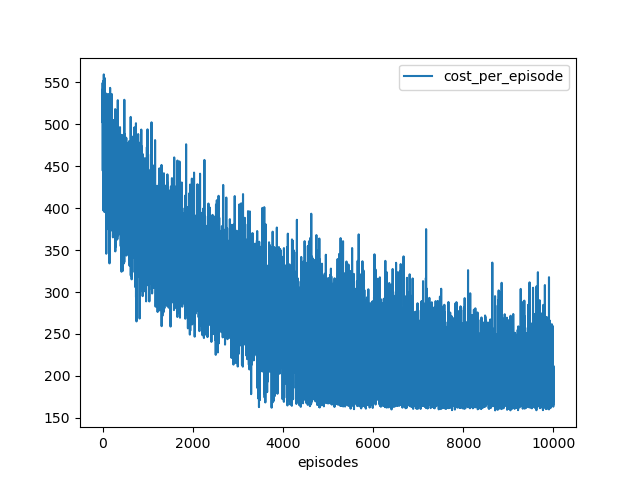

Text(0.5, 0, 'episodes')

In [35]:
plt.figure()
l = range(len(cost_episode))
plt.plot(l, cost_episode)
plt.legend(['cost_per_episode'])
plt.xlabel('episodes')

<IPython.core.display.Javascript object>


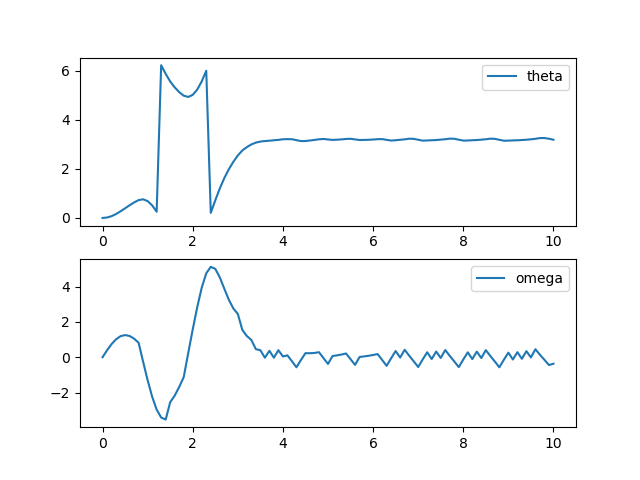

<IPython.core.display.Javascript object>


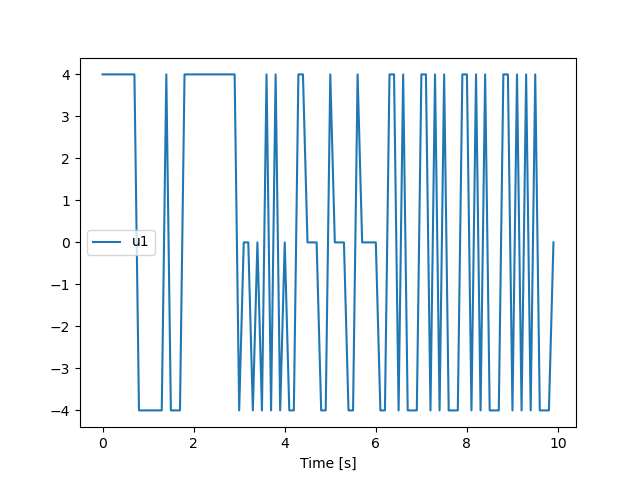

Text(0.5, 0, 'Time [s]')

In [36]:
# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')

In [37]:
# now we can also create an animation
pendulum.animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAhQZtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzA5NSBiYWVlNDAwIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DQpliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOONPsPaEewkllXn2fy
1TN9UNOLuVpCg16nA3KBIICjbY2TQND3n5QxoJFUYpmvY7NlYgUyYC0Gbe9iLYzS+7C8JQLMZGRo
QnlmwO88l0TfdHNayNY+bQVlMTywhlcWFi3wo5I9OWpDp/O5o69Dh9VCAAA7ArAJGcKIhsON1YTX
SZ+7DpOh956UxbX9JHiFm0hB1kTY014bpjWhUKbF1FKiWxxbaOI12ZNFiDZaGNwvH4gMJme2NhsB
5ycEpJAa5YCClinPEpetz3uLnx008RArAv0e7lBwVdLoRR8HR6ljB55JGV7+XQwNsLbloxnm0Jci
Y1GRGLBEdeoJvx//X6nip2NswUwAubMfy1/YSD/ic5nyOT5RA3uorBCtV2FftGmbYiXunqiOpVpK
I+2r/Ap+Q0WuKVcxKnkzawE1OQzWCRkf+/hKqsKQFeQo8ui0BLWjORcr7fRcv6mtXXQrHNZ5TLXy
vz07HuJ0r1jP1MHeAAstco/y6d/gZv97QP3wjOzkveqCynjnvrx6EsCzZ4ktjM8W1lNaV4DuFxm+
uCz0QBtjwO3A5ZbLNFqrcgL3Ukg4hJjwVAs35DuQE4AAAAMAAAMAAC1tZ+0C8UCh2J0J5/pDiii5
fGN0lno0x71eIwtqvVtzZM5OWEQXCzJMSQ8wkDATruAlQZiLkYQ+di+wiiht8ZvNQdd8uR79qE1F
qvAk5pfFUnaB6zO6UwJib7iwEH6A1bJyuPPGD4rlIqCHsFXguGD2KPA1iP34Qw9JkAnzUcr/k2qn
KRU9EoLbicGmE1AZJwtiVcowVv+c0HKt6+sr5xFpRoDUImMcSRMReLZNXTkCCjy8n6nVH61qJhfm
hCO//LzUoKv77fnrjHfdW6zy0QmHYK98FRJTz1o90MVrW/Ku1u7uRgOuRnNp9LGfmQZvTGf9e6Q2
oms6hL3057RHcGNLz64VFsUozdy0kWmqno8+9da8otXThL9uPiNFrsJrWijrj421mWJViSYh3Sxn
5kIlF8n738Pjy1ea+Idqsp/FvJOd5c5G3gAAAwAAAwAABkH6py0Jx4TQ32auyKpLkDaA9SmxMANa
YdhKOJknWTWXdYD7bpIrzQxDHYZnDddLpLEjBBaOKQmGAiWZ/tLlYcQ//v2nc/zExlsa5u/yGkeX
KXivoFMS1gX9kv3N8LBOINck9ZD6RpZNmy4+sz6QTzYzZJTijA8zkrcnJKOAAmmaXhKobJfWDrgt
5CK+2OGr7aYg5E6vCxFQ9kU34x+Yv1yMjZhs64CbhsNbRkJXXw6o9RxwCkl1G/hdYoGBrNZZw5tb
QgtiQZQlM1m7jhLw32sNIpcq+P3bhG6TWMcGmnn2+tEYxT0DYXbgckkOhLNegoVXfgsaLXFgAoFX
6m9qeRC63iQN4XeLZwWiIHuPNQHSg5vdzWNIchCgpt6LjJ67UIjotLW2Fv0pHFwtT8OeyIPxTQxD
ccpZgPaDeIkPM2KMcpTyEqHsbaQOpAUxa7LMLSeet7l6XQ+QQWEJbgEZphqgfemg9xnTmTUPrlg3
P7Y1AMYEyM5FSfnESZVDH8iSwodsUYJfcgFJyb/r3Hm1+v8PNX2yahrLIjH7UtPzUaJ3FLYJOhRf
jZGZ/QitJG+73wmBodHK0OzP3M4tKLsAjPSSz34KebADxSgfnB/44qkNvl/4tzgR9MB7vxxkOchO
mCPR3PnAAB5tb/tea/kXy9VH8NQ4FBDNyLt8i8cabtHuYw8vbZZybHzQyfaUQ2bfjCEU1Xav/8vq
37EcNpmXaPM9pXXmtTKwi+HGJ0ja/LVLMHeQvj696xWW6/XOm7hDgfvxYuDd8swFkJCzYWRypKdo
l6MumbzbJRR8VUHWGCpA0wSX9+vDTacuVikH0Z4ynVubV9BhKsNnsK/gUH+gCh87EnpB5zcIxN6E
K9zxsPZJYUybQquzFJ3gZcF/+PEcZIUseHFyfdE6MRzB6rwPM4+bsKTN5g+cr2yO/cxpnF3gTREE
ibbv9GlRzsYwQ1ZLouZale7UH0TWKX6LndRrYwJuWWFzznsKdjyVBPlV/lpKMRQN1Y//fUGay6oT
sXZZ7ppiDA7k2zEtC2B+eDSZ9iKwzisUV2Op98nLTXvNNUEo5H3kI78Wf8wCNAsF+/+yX0AFGoX3
oI0CEk1nbFCLe/rQzln7oxw6OARx1a0jaOx6mBsqXHWOX9+ZfWOHOGold74U9HdrBBXhHdAUk48F
hmZgtOL0SLFWpcY6rT5lZS1OoQY4UIfUhXuUb0AGVJeLv/1cbWiOrxt3toAALww7Icn/aQAAAwAP
/O0WEKj7fYaDhc+uqW+EQAMhHdry5cQ68skeQPPqxsjF2R6jdMNArDE8y6EQztWvqv2aSH3z615I
BNfR/sGrXo27iCL6wcE6GcuZJ+rq5Aw09Z6O/8KuEH3alntuSAf/HmBspdMg/gXHr49Nb88BJo70
kcXlhHNfw5vuOIPKitNycKu9tKJ9rrhtehOCMIdgVGnxa3dqxlR76Pcl2ehlRIHUs7gSK2fv3ylf
A2ZDeh20z6Z8b5fSr1ertsC489yQgQSQsWTEVwvsHVaI5zVsybOPHQuOK835J0EaFdLHFptAivlC
OirCNY9CM/+wlcYo0h4Si/fN20xsQSvoXS/y7qlaYg/EClfilpFM+x+gQeGsmWazmVf/P5mb4x+2
k1nYG//CMOLUnh/3ZzLTVqaV2kcSvNseVDTz2HFU/wQWKxe+DfUB2D+k/Wmu2XEkssrRQ3hfp0Vd
eSqg5blrlhGF/jqf73N43

<IPython.core.display.Javascript object>


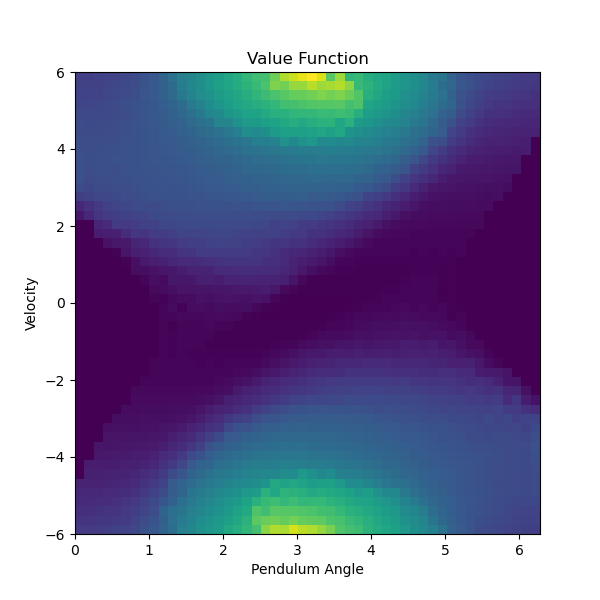

<IPython.core.display.Javascript object>


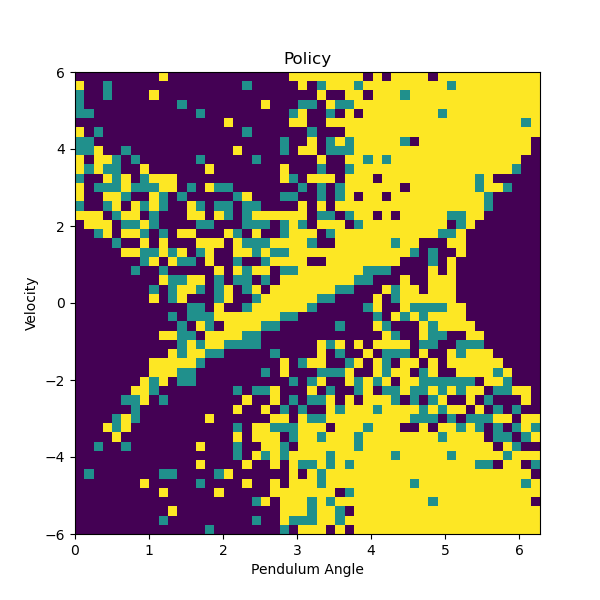

Text(0.5, 1.0, 'Policy')

In [38]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2

value_function, policy = get_policy_and_value_function(q_table)

# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')